# Art Zaragoza

Project #6 - Date: 1/10/2025

## Project Name: Stock Market News Sentiment Analysis and News Summmarization

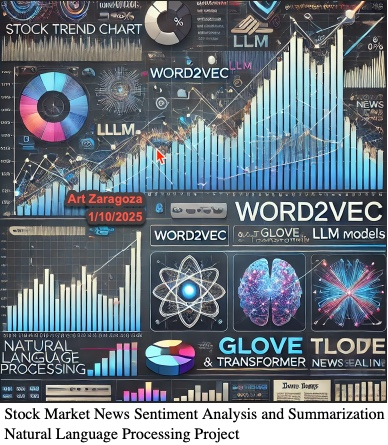

## **Problem Statement**

### Business Context

The prices of the stocks of companies listed under a global exchange are influenced by a variety of factors, with the company's financial performance, innovations and collaborations, and market sentiment being factors that play a significant role. News and media reports can rapidly affect investor perceptions and, consequently, stock prices in the highly competitive financial industry. With the sheer volume of news and opinions from a wide variety of sources, investors and financial analysts often struggle to stay updated and accurately interpret its impact on the market. As a result, investment firms need sophisticated tools to analyze market sentiment and integrate this information into their investment strategies.

### Problem Definition

With an ever-rising number of news articles and opinions, an investment startup aims to leverage artificial intelligence to address the challenge of interpreting stock-related news and its impact on stock prices. They have collected historical daily news for a specific company listed under NASDAQ, along with data on its daily stock price and trade volumes.

As a member of the Data Science and AI team in the startup, you have been tasked with analyzing the data, developing an AI-driven sentiment analysis system that will automatically process and analyze news articles
<font color=yellow> - **to gauge market sentiment, and summarizing the news at a weekly level**,</font>
to enhance the accuracy of their stock price predictions and optimize investment strategies. This will empower their financial analysts with actionable insights, leading to more informed investment decisions and improved client outcomes.

### Data Dictionary

* `Date` : The date the news was released
* `News` : The content of news articles that could potentially affect the company's stock price
* `Open` : The stock price (in \$) at the beginning of the day
* `High` : The highest stock price (in \$) reached during the day
* `Low` :  The lowest stock price (in \$) reached during the day
* `Close` : The adjusted stock price (in \$) at the end of the day
* `Volume` : The number of shares traded during the day
* `Label` : The sentiment polarity of the news content
    * 1: positive
    * 0: neutral
    * -1: negative

### **Note**: If the free-tier GPU of Google Colab is not accessible (due to unavailability or exhaustion of daily limit or other reasons), the following steps can be taken:

1. Wait for 12-24 hours until the GPU is accessible again or the daily usage limits are reset.

2. Switch to a different Google account and resume working on the project from there.

3. Try using the CPU runtime:
    - To use the CPU runtime, click on *Runtime* => *Change runtime type* => *CPU* => *Save*
    - One can also click on the *Continue without GPU* option to switch to a CPU runtime (kindly refer to the snapshot below)
    - The instructions for running the code on the CPU are provided in the respective sections of the notebook.

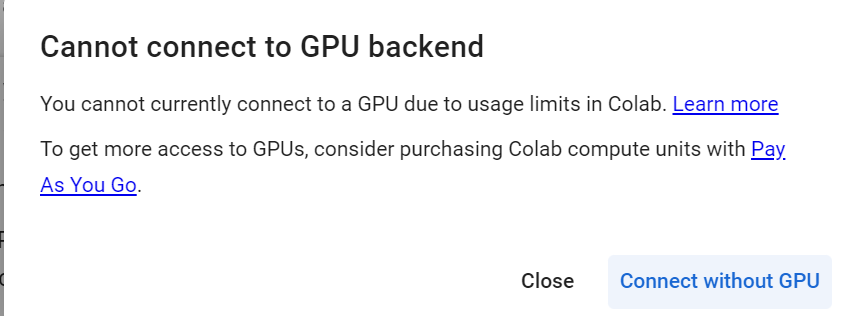

I've exhausted the 100 Compute units on my paid plan...

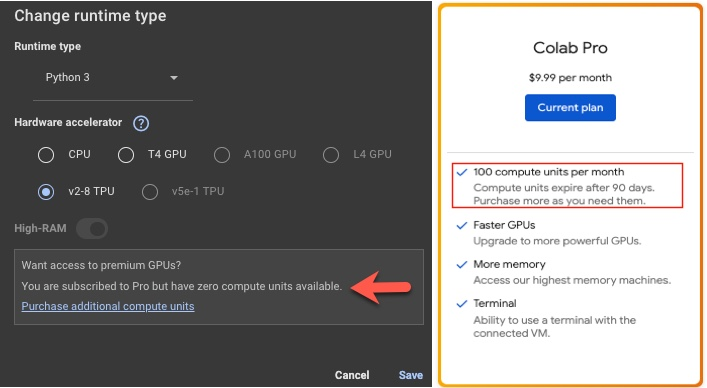

## **Installing and Importing the necessary libraries**

In [ ]:
%%time
# installing the sentence-transformers and gensim libraries for word embeddings
!pip install -U sentence-transformers gensim transformers tqdm -q

CPU times: user 21 ms, sys: 2.64 ms, total: 23.6 ms
Wall time: 2.71 s


In [ ]:
%%time
# To manipulate and analyze data
import pandas as pd
import numpy as np

# To visualize data
import matplotlib.pyplot as plt
import seaborn as sns

# To used time-related functions
import time

# To parse JSON data
import json

# To build, tune, and evaluate ML models
# from sklearn.ensemble import DecisionTreeClassifier # Incorrecct import
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier # Update import replacing commented sklearn.ensemble import

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score

# To load/create word embeddings
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec

# To work with transformer models
import torch
from sentence_transformers import SentenceTransformer

# To implement progress bar related functionalities
from tqdm import tqdm
tqdm.pandas()

# To ignore unnecessary warnings
import warnings
warnings.filterwarnings('ignore')

CPU times: user 22.1 s, sys: 2.47 s, total: 24.6 s
Wall time: 46.6 s


In [ ]:
# Check library versions
print("pandas:   ", pd.__version__)
print("numpy:    ", np.__version__)
print("seaborn:  ", sns.__version__)
print("torch:    ", torch.__version__)

pandas:    2.2.2
numpy:     1.26.4
seaborn:   0.13.2
torch:     2.5.1+cu121


## **Loading the dataset**

In [ ]:
from google.colab import drive # Mount drive
drive.mount('/content/drive')  # Dataset is in Google Drive

Mounted at /content/drive


In [ ]:
stock_news = pd.read_csv("/content/stock_news.csv") # Read the CSV file.

In [ ]:
stock = stock_news.copy() #Create a copy of the dataset

## **Data Overview**

### Display a few random rows of the dataset

In [ ]:
stock.sample(n=10, random_state=42) # Randomly select 10 rows and set a random seed for reproducibility (i.e., to always get the same random rows each time you run the code).

Date                                               News       Open  \
157  2019-01-30   Google and Facebook disenabled their research...  40.812500   
341  2019-04-30   In early trading, U.S. stock futures were fla...  50.764999   
315  2019-04-17   Facebook, aiming to compete with Alexa, Siri,...  49.884998   
234  2019-03-14   The European Union's Competition Commissioner...  45.974998   
155  2019-01-30   Alibaba, the Chinese e-commerce giant and sec...  40.812500   
274  2019-03-26   Tesla's stock rose by 8.15% in premarket trad...  47.915001   
304  2019-04-12   In this article, a Chinese-Taiwanese group le...  65.267502   
227  2019-03-06   Fitbit introduced its most affordable smartwa...  43.900002   
278  2019-03-27   Lyft raised the price range for its IPO due t...  47.187500   
185  2019-02-12   Akamai Technologies reported stronger than pr...  66.817497   

          High        Low      Close     Volume  Label  
157  41.537498  40.057499  39.939968  244439200      0  
341  50.849998  49.777500  48.708790  186139600      0  
315  50.845001  49.652500  49.305897  115627200     -1  
234  46.025002  45.639999  44.596924   94318000     -1  
155  41.537498  40.057499  39.939968  244439200      0  
274  48.220001  46.145000  45.339684  199202000      1  
304  65.827499  65.169998  64.211540   67181600     -1  
227  44.480000  42.567501  42.227238  161584400      0  
278  47.439999  46.637501  45.747482  119393600      1  
185  67.062500  65.862503  64.805229   94487200      1

### Shape of the dataset

In [ ]:
stock.shape # Check the shape of the data

(349, 8)

### Data types of the columns

In [ ]:
stock.dtypes # Check the data types

Date       object
News       object
Open      float64
High      float64
Low       float64
Close     float64
Volume      int64
Label       int64
dtype: object

### Convert the 'Date' column in the 'stock' DataFrame to datetime format

In [ ]:
stock['Date'] = pd.to_datetime(stock['Date'])  # Convert the 'Date' column in the 'stock' DataFrame to datetime format.

Check after conversion

In [ ]:
stock.dtypes # Notice 'Date' column converted from object to datetime format.

Date      datetime64[ns]
News              object
Open             float64
High             float64
Low              float64
Close            float64
Volume             int64
Label              int64
dtype: object

### Review the statistical summary

In [ ]:
pd.set_option('display.float_format', '{:.2f}'.format) # Set display options to show 2 decimal places
stock.describe() # Check the statistical summary

Date   Open   High    Low  Close       Volume  \
count                            349 349.00 349.00 349.00 349.00       349.00   
mean   2019-02-16 16:05:30.085959936  46.23  46.70  45.75  44.93 128948236.10   
min              2019-01-02 00:00:00  37.57  37.82  37.30  36.25  45448000.00   
25%              2019-01-14 00:00:00  41.74  42.24  41.48  40.25 103272000.00   
50%              2019-02-05 00:00:00  45.97  46.03  45.64  44.60 115627200.00   
75%              2019-03-22 00:00:00  50.71  50.85  49.78  49.11 151125200.00   
max              2019-04-30 00:00:00  66.82  67.06  65.86  64.81 244439200.00   
std                              NaN   6.44   6.51   6.39   6.40  43170314.92   

       Label  
count 349.00  
mean   -0.05  
min    -1.00  
25%    -1.00  
50%     0.00  
75%     0.00  
max     1.00  
std     0.72

Observations:

For the 349 days in this range, these were the transactional highlights.
- Stock Volume Max:    244,439,200
- Highest Stock Price: 67.06
- Lowest Stock Price:  36.25

### Checking for duplicate values

In [ ]:
stock.duplicated().sum() #Complete the code to check the duplicate values

0

Observations:

For the 349 days in this range,
- No duplicates detected

### Checking for missing values

In [ ]:
stock.isnull().sum() # Complete the code to check for missing values in the data

Date      0
News      0
Open      0
High      0
Low       0
Close     0
Volume    0
Label     0
dtype: int64

Observations:

For the 349 days in this range,
- No missing values detected

## **Exploratory Data Analysis**

### Univariate Analysis

#### Observations on Label

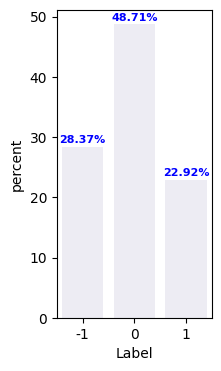

In [ ]:
sns.set_palette("Purples")                                   # Set color to violet for the bars.

plt.figure(figsize=(2, 4))                                   # Adjust width and height.

ax = sns.countplot(data=stock, x="Label", stat="percent")    # Create the count plot

# Add percentage values at the top of each bar
total = len(stock)                                           # Total number of items in the dataset
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height:.2f}%',                            # Display percentage with 2 decimals
                (p.get_x() + p.get_width() / 2., height),    # Position at the top of the bar
                ha='center', va='center',                    # Alignment
                fontsize=8, color='blue', fontweight='bold', # Styling
                xytext=(0, 5), textcoords='offset points')   # Adjust text position

plt.show()                                                   # Show the plot

Observations:

For the 349 days in this range, for the reported News,
- 48.71% were considered Neutral.
- 22.92% were considered Positive.
- 28.37% were considered Negative.
- There was about similar percentages of Positive and Negative with the balance being Neutral.

#### Density Plot of Price (Open, High, Low, Close)

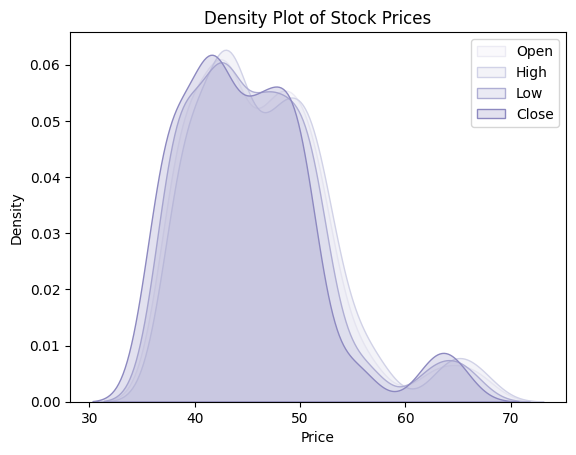

In [ ]:
# Density Plot of Price (Open,High,Low,Close)
for i in ["Open","High","Low","Close"]:
    sns.kdeplot(stock[i], label=i, shade=True)
plt.xlabel("Price")
plt.ylabel("Density")
plt.title("Density Plot of Stock Prices")
plt.legend()
plt.show()

Observations:

For the 349 days in this range,
- Stock Price mostly landed in the 40-50 range.

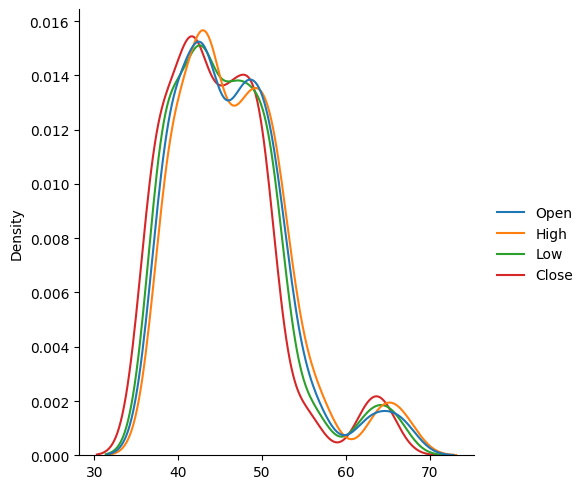

In [ ]:
sns.displot(data=stock[['Open','High','Low','Close']], kind="kde", palette="tab10"); # Plot a density plot of ["Open","High","Low","Close"] all in a single plot

Same as above but presented in colors to view more clerly.

#### Observations on Volume

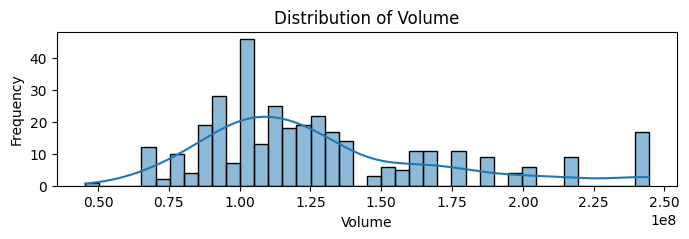

In [ ]:
#Plot a histogram of Volume
plt.figure(figsize=(8, 2))
sns.histplot(stock['Volume'], bins=40, kde=True)
plt.xlabel('Volume')
plt.ylabel('Frequency')
plt.title('Distribution of Volume')
plt.show()

Observations:

For the 349 days in this range,
- The distribution of the Transactional Volume mostly spdread between 9x1e8 to 1.3x1e8 or,
- Most Transactional Volume values fell between 900 million and 1.3 billion.

#### Observations on News length

In [ ]:
stock['news_len'] = stock['News'].apply(lambda x: len(x.split(' '))) # Calculating the total number of words present in the news content column.
stock['news_len'].describe()                                         # Print the statistical summary for the news content length after splitting into words.

count   349.00
mean     49.31
std       5.73
min      19.00
25%      46.00
50%      50.00
75%      53.00
max      61.00
Name: news_len, dtype: float64

Observations:
- There are 350 rows of News.
- This calculation is most critical on several fronts:
- Model optimization arguments like tokens and Context window.
- n_ctx model parameter determines how much text (in tokens) the model can process or “remember” in a single pass.

### Bivariate Analysis

#### Correlation analysis

In [ ]:
stock.dtypes # Observe which columns have numerical data

Date      datetime64[ns]
News              object
Open             float64
High             float64
Low              float64
Close            float64
Volume             int64
Label              int64
dtype: object

Observations:
- News (Object) and Date (datetime64) will be skipped as non-numeric columns.

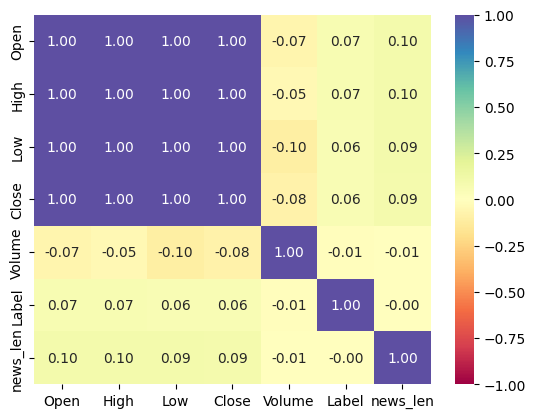

In [ ]:
numeric_columns = stock.select_dtypes(include=['number']) # Filter only numeric columns

# Plot the heatmap for numeric columns only
sns.heatmap(
    numeric_columns.corr(), annot=True, vmin=-1, vmax=1, fmt=".2f", cmap="Spectral"
)
plt.show()

Observations:
- Volume had the strongest correlation when the Stock Price was Low.
- Sentiment was strongest (Neg, Pos or Neutral) when the Stock Price was High or at Opening.
- News had about the same correlation on the Stock Price regardless of Price.
- Stock Price at Close, Low, High and Open are directly correlated.

#### Label vs Price (Open, High, Low, Close)

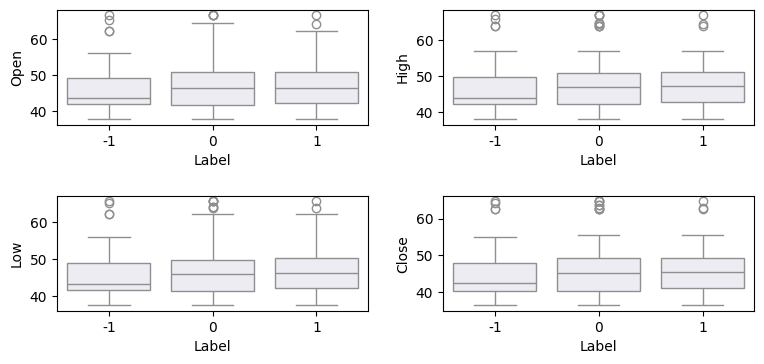

In [ ]:
plt.figure(figsize=(8, 4))

for i, variable in enumerate(['Open', 'High', 'Low', 'Close']):
    plt.subplot(2, 2, i + 1)
    sns.boxplot(data=stock, x="Label", y=variable) # Label = Sentiment (1) - Positive, (0) - Neutral, (-1) - Negative
    plt.tight_layout(pad=2)

plt.show()

Observations:
- Sentiment was mostly Neutral averaging about 50% of the time on Stock Price between 42-48.
- Sentiment was about equally Negative and Positive, but more Negative when the price ranged in the low 40s.

#### Label vs Volume

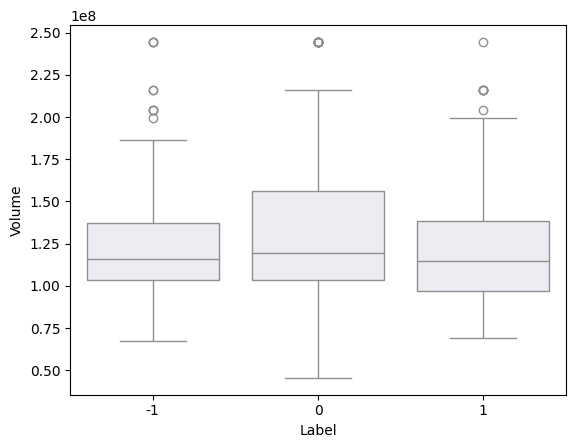

In [ ]:
sns.boxplot(
    data=stock, x="Label", y="Volume"  # # Label = Sentiment (1) - Positive, (0) - Neutral, (-1) - Negative
);

Observations:
- Negative and Positive Sentiment was evenly distributed mostly when the volume of transactions were below the 1.2 billion range.
- However the distribution of Negative, Positive to Neutral with that range of transactions was 2 : 1.  There were twice as many neutral for either Negative or Positive sentiments.

#### Date vs Price (Open, High, Low, Close) View on Random rows

In [ ]:
stock_daily = stock.groupby('Date').agg(
    {
        'Open': 'mean',
        'High': 'mean',
        'Low': 'mean',
        'Close': 'mean',
        'Volume': 'mean',
    }
).reset_index()                             # Group the 'stocks' DataFrame by the 'Date' column

stock_daily.set_index('Date', inplace=True) # Index
stock_daily.sample(n=10, random_state=42)   # Random selection of rows. But the same ones used whenever randon is chosen.

Open       High        Low      Close       Volume
Date                                                               
2019-02-05  52.459999  53.162498  52.032501  50.767143  127985200.0
2019-01-02  41.740002  42.244999  41.482498  40.246914  130672400.0
2019-03-25  47.877499  47.994999  46.650002  45.813015  175381200.0
2019-01-08  53.474998  54.507500  51.685001  50.787209  216071600.0
2019-04-03  43.922501  44.437500  43.492500  42.684212  109744800.0
2019-01-30  40.812500  41.537498  40.057499  39.939968  244439200.0
2019-01-17  38.549999  39.415001  38.314999  37.670460  119284800.0
2019-02-25  43.540001  43.967499  43.487499  42.290981   87493600.0
2019-03-20  46.557499  47.372501  46.182499  45.672226  124140800.0
2019-01-22  39.102501  39.182499  38.154999  37.051727  121576000.0

Observations:
- Random sample shows the date's corresponding Stock Price: Volume, Open, Close, Low and High.

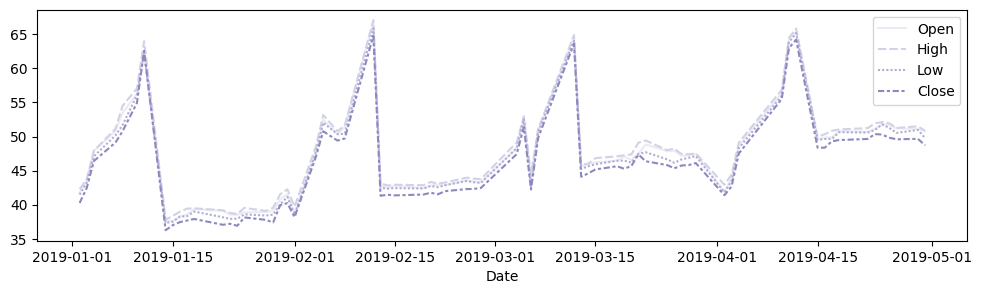

In [ ]:
plt.figure(figsize=(12,3))
sns.lineplot(stock_daily.drop("Volume", axis=1)); # Lineplot of variables except Volume

Observations:
- There's a cyclic pattern with the increase of the stoc as well as its drop.
- The first 1/2 of the month, each month, the stock surges. (Two weeks.)
- The stock's valuation drops suddenly in the middle of the month.
- For the second 1/2 of the month the stock valuation remains mostly low. (two weeks)
- The pattern repeats for the 4 and 1/2 months or full duration of the data collected.

#### Volume vs Close Price

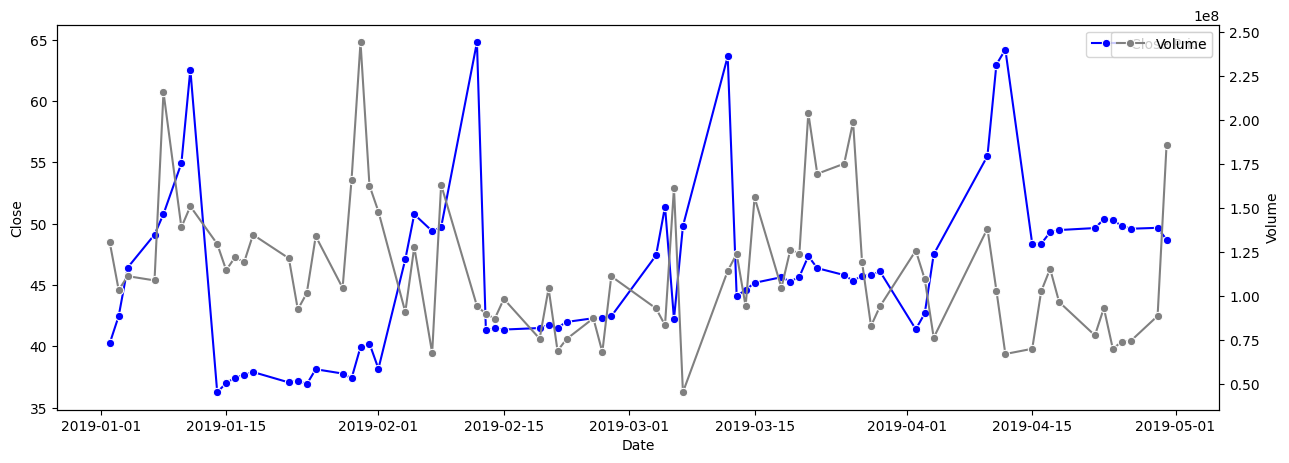

In [ ]:
fig, ax1 = plt.subplots(figsize=(15,5))      # Create a figure and axis
sns.lineplot(data=stock_daily.reset_index(), x='Date', y='Close', ax=ax1, color='blue', marker='o', label='Close Price') # Lineplot on primary y-axis
ax2 = ax1.twinx()                            # Create a secondary y-axis
sns.lineplot(data=stock_daily.reset_index(), x='Date', y='Volume', ax=ax2, color='gray', marker='o', label='Volume') # Lineplot on secondary y-axis
ax1.legend(bbox_to_anchor=(1,1));            # Legend set to the Volume data

Observations:
- Similar highlights as above correlating the Volume and Stock Close Price cyclic patterns.
- This chart provides more resolution with the Volume.
- Same pattern, two weeks of a gradual Stock Price gradual price increase followed by a sharp drop in the middle of the month and a steady increase but on the lower range for the 2nd half of the month.

## **Data Preprocessing - - - - -**

In [ ]:
pd.set_option('display.float_format', '{:.2f}'.format) # Set display options to show 2 decimal places
stock.describe() # Check the statistical summary

Date   Open   High    Low  Close       Volume  \
count                            349 349.00 349.00 349.00 349.00       349.00   
mean   2019-02-16 16:05:30.085959936  46.23  46.70  45.75  44.93 128948236.10   
min              2019-01-02 00:00:00  37.57  37.82  37.30  36.25  45448000.00   
25%              2019-01-14 00:00:00  41.74  42.24  41.48  40.25 103272000.00   
50%              2019-02-05 00:00:00  45.97  46.03  45.64  44.60 115627200.00   
75%              2019-03-22 00:00:00  50.71  50.85  49.78  49.11 151125200.00   
max              2019-04-30 00:00:00  66.82  67.06  65.86  64.81 244439200.00   
std                              NaN   6.44   6.51   6.39   6.40  43170314.92   

       Label  
count 349.00  
mean   -0.05  
min    -1.00  
25%    -1.00  
50%     0.00  
75%     0.00  
max     1.00  
std     0.72

Observations:
- Ignore the date stats, as they will not be meaningful.
- STD is about 6.5 dollars for all the Stock Price baselines.

### Handling NaN data on Date column

In [ ]:
stock["Date"].fillna("Unknown", inplace=True) # Replace NaN with a Default Value (e.g., “Unknown” or a placeholder)
stock["Date"].describe()

count                              349
mean     2019-02-16 16:05:30.085959936
min                2019-01-02 00:00:00
25%                2019-01-14 00:00:00
50%                2019-02-05 00:00:00
75%                2019-03-22 00:00:00
max                2019-04-30 00:00:00
Name: Date, dtype: object

Observations:
Date is the only column data that requires special handling/processing as all other is numerical.

### Train | Test | Validation Split

In [ ]:
X_train = stock[(stock['Date'] < '2019-04-01')].reset_index()    # Select all rows where the 'Date' is before '2019-04-01'
X_val = stock[(stock['Date'] >= '2019-04-01') & (stock['Date'] < '2019-04-16')].reset_index()    # Select all rows where the 'Date' is from '2019-04-01 to '2019-04-16' (excluded)
X_test = stock[stock['Date'] >= '2019-04-16'].reset_index()      # Select all rows where the 'Date' is from '2019-04-16' till the end.

In [ ]:
# 'Label' column is the target variable (lower cse variables)
y_train = X_train["Label"].copy()
y_val = X_val["Label"].copy()
y_test = X_test["Label"].copy()

In [ ]:
# Print the shape of X_train,X_val,X_test,y_train,y_val and y_test
print("\nTrain data shape",X_train.shape)
print("Validation data shape",X_val.shape)
print("Test data shape ",X_test.shape)
line= '_' * 25
print(line)
print("\nTrain Label shape",y_train.shape)
print("Validation Label shape",y_val.shape)
print("Test Label shape ",y_test.shape)


Train data shape (286, 9)
Validation data shape (21, 9)
Test data shape  (42, 9)
_________________________

Train Label shape (286,)
Validation Label shape (21,)
Test Label shape  (42,)


## **Word Embeddings - - - - -**. Yay! Let the fun part commence

### Model 1 - Word2Vec Diagram

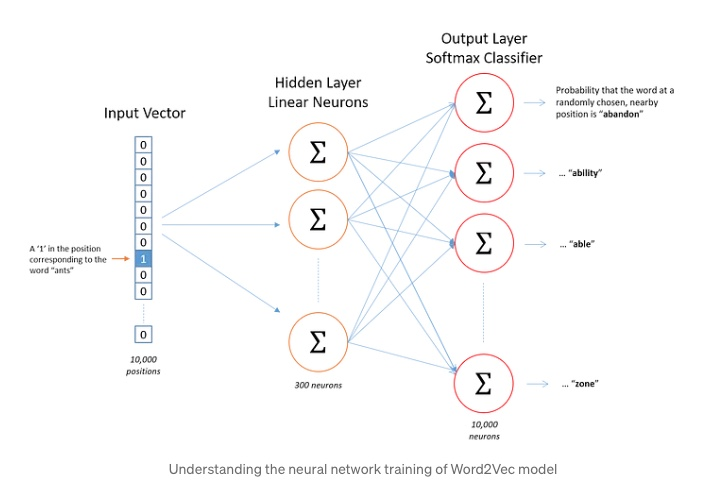

### Model 1 - Word2Vec Model Setup

In [ ]:
words_list = [item.split(" ") for item in stock['News'].values] # Creating a list of all words in our data

In [ ]:
# Creating an instance of Word2Vec
vec_size = 300 # Determines the number of features used to represent each word in the vector space. A higher vec_size can increase computational complexity as it captures more nuances.
model_W2V = Word2Vec(words_list, vector_size = vec_size, min_count = 1, window=5, workers = 6) # Model will learn these embeddings by analyzing word co-occurrences within a context window of 5 words.

<h3>Word2Vec Parameters for our Model</h2>

  <table>
    <tr>
      <th>Parameter</th>
      <th>Description</th>
      <th>Value</th>
      <th>Comment</th>
    </tr>
    <tr>
      <td>`vec_size`</td>
      <td>Dimensionality of word vectors</td>
      <td>300</td>
      <td>It determines the number of features used to represent each word in the vector space.</td>
    </tr>
    <tr>
      <td>`model_W2V`</td>
      <td>Word2Vec model instance</td>
      <td>-</td>
      <td>The Word2Vec model learns these representations by analyzing the co-occurrence patterns of words in the input text.</td>
    </tr>
    <tr>
      <td>`words_list`</td>
      <td>Input data (list of sentences or words)</td>
      <td>-</td>
      <td>This argument represents the input data for the model. The model will learn word embeddings based on the words and their contexts within these sentences.</td>
    </tr>
    <tr>
      <td>`vector_size`</td>
      <td>Dimensionality of word vectors</td>
      <td>300</td>
      <td>In this case, it is set to 300, meaning that **each word** will be represented by a vector with 300 dimensions.</td>
    </tr>
    <tr>
      <td>`min_count`</td>
      <td>Minimum word frequency to be included</td>
      <td>1</td>
      <td>Specifies the minimum number of times a word must appear in the training data to be included in the model's vocabulary.</td>
    </tr>
    <tr>
      <td>`window`</td>
      <td>Context window size</td>
      <td>5</td>
      <td>Context window around a target word. The model considers words within a window before and after the target word **to learn its vector representation**.</td>
    </tr>
    <tr>
      <td>`workers`</td>
      <td>Number of worker threads</td>
      <td>6</td>
      <td>Using multiple workers can significantly speed up the training process, especially for large datasets.</td>
    </tr>
  </table>

</body>
</html>

In [ ]:
print("Length of the vocabulary is", len(list(model_W2V.wv.key_to_index))) # Size of the vocabulary or number of unique words that the Word2Vec model has learned representations for.

Length of the vocabulary is 4682


The **Number of Unique Words** or **Vocabulary** above **(4692)** can be usef for the following purposes:

- <font color=yellow>Evaluating model coverage: </font>Determine how well the model covers the vocabulary of a specific dataset.

- <font color=yellow>Resource allocation: </font>Estimate the memory requirements for storing and using the word embeddings.

- <font color=yellow>Model comparison: </font>Compare the vocabulary sizes of different Word2Vec models trained on different datasets.

Let's check out a few word embeddings obtained using the model.

In [ ]:
word = "stock"     # Selected word used frequently.
model_W2V.wv[word] # Observe the word embedding of a selected word

array([-4.19601053e-03,  3.78526896e-02,  8.21894407e-03,  1.16648301e-02,
        1.25771412e-03, -5.74814267e-02,  2.89080292e-02,  8.79899710e-02,
        3.79001605e-03, -2.21128259e-02,  6.06034091e-03, -2.09432617e-02,
       -4.73199738e-03,  1.50754089e-02, -2.56939512e-02, -2.71770842e-02,
        2.32006367e-02, -4.16877959e-03,  6.60845311e-03, -2.49691680e-02,
       -2.29730904e-02,  7.96799362e-03,  2.95192264e-02,  1.50224334e-02,
        2.44271513e-02,  5.86084672e-04, -3.57161835e-02,  8.61013308e-03,
       -2.86978502e-02, -4.14595380e-02,  1.01249758e-02, -2.73376964e-02,
        4.81545972e-03, -8.84498283e-03, -1.60114560e-03,  2.33421847e-02,
        1.25492699e-02, -3.44886966e-02, -2.66792951e-03, -1.24537256e-02,
       -2.01210361e-02,  3.77422688e-03,  4.32393790e-06, -2.07194965e-02,
        2.00429410e-02,  3.82277556e-02,  8.80036131e-03,  1.77631751e-02,
        1.81522031e-04,  2.35824287e-02,  1.18666738e-02, -9.40604787e-03,
       -2.08203252e-02,  

In [ ]:
word = "economy"   # Second selected word
model_W2V.wv[word] # Observe the word embedding of the second selected word

array([-1.1736044e-03,  5.2003744e-03,  3.2191728e-03,  1.9107534e-03,
       -1.1238786e-03, -1.1351875e-02,  6.6732639e-03,  1.5558835e-02,
       -1.9695323e-03, -2.1757470e-03, -2.4364782e-03, -3.4592925e-03,
        7.8855694e-04, -2.9482230e-04, -4.2081038e-03, -1.7477073e-03,
        7.2091944e-03,  1.8852394e-03,  3.7128963e-03, -2.6980138e-03,
       -5.7870648e-03,  2.7897877e-03,  3.9081420e-03, -8.2981534e-04,
        1.2219461e-03, -1.2268197e-03, -7.1122018e-03,  2.2713640e-03,
       -6.5919384e-03, -9.6495701e-03, -1.9761045e-03, -6.5300972e-03,
        2.9246022e-03, -2.6909986e-03, -2.6535401e-03,  5.8842916e-03,
       -1.6133848e-04, -5.3638699e-03, -7.8866324e-05, -2.9484737e-03,
       -5.7377932e-03,  7.9797016e-04,  1.4267055e-03, -3.8825008e-03,
        3.9118105e-03,  3.8020120e-03, -6.2302058e-04,  1.1090605e-03,
       -2.2799992e-05,  1.0084192e-03,  4.6470133e-03, -4.1734446e-03,
       -4.0785726e-03,  4.5388046e-04, -2.8474401e-03,  6.9285952e-03,
      

In [ ]:
words = list(model_W2V.wv.key_to_index.keys()) # Retrieve the words present in the --Word2Vec-- model's vocabulary
wvs = model_W2V.wv[words].tolist()             # Retrieve word vectors for all the words present in the model's vocabulary
word_vector_dict = dict(zip(words, wvs))       # Create a dictionary of words and their corresponding vectors

In [ ]:
def average_vectorizer_Word2Vec(doc):
    # Initializing a feature vector for the sentence
    feature_vector = np.zeros((vec_size,), dtype="float64")

    # Create a list of words in the sentence that are present in the model vocabulary
    words_in_vocab = [word for word in doc.split() if word in words]

    # Add the vector representations of the words
    for word in words_in_vocab:
        feature_vector += np.array(word_vector_dict[word])

    # Divide by the number of words to get the average vector
    if len(words_in_vocab) != 0:
        feature_vector /= len(words_in_vocab)

    return feature_vector

In [ ]:
# Create a dataframe of the vectorized documents
start = time.time()

X_train_wv = pd.DataFrame(X_train["News"].apply(average_vectorizer_Word2Vec).tolist(), columns=['Feature '+str(i) for i in range(vec_size)])
X_val_wv = pd.DataFrame(X_val["News"].apply(average_vectorizer_Word2Vec).tolist(), columns=['Feature '+str(i) for i in range(vec_size)])
X_test_wv = pd.DataFrame(X_test["News"].apply(average_vectorizer_Word2Vec).tolist(), columns=['Feature '+str(i) for i in range(vec_size)])

end = time.time()
print('Time taken ', (end-start))

Time taken  1.4526166915893555


In [ ]:
print(X_train_wv.shape,'train split\n', X_val_wv.shape,'validation split\n', X_test_wv.shape,'test split\n') # Train-Validatio-Test Splits

(286, 300) train split
 (21, 300) validation split
 (42, 300) test split



Observations:
- Notice the dimensionality of the vectors is 300 columns long.
- We will use a fairly large percentage (95%) of the dataset for training the model.
- The Validation will be split at 14% of the available data.
- The Test will be split at 7% of the available data.

### Model 2 - GloVe Diagram

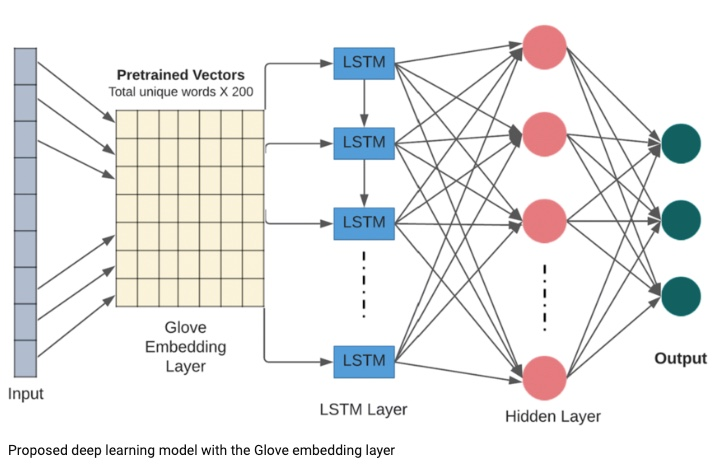

### Model 2 - GloVe Model Setup

In [ ]:
# Download the GloVe model (Stanford's) if it doesn't exist
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

# Convert GloVe to word2vec format
glove_input_file = 'glove.6B.100d.txt'
word2vec_output_file = 'glove.6B.100d.txt.word2vec'
glove2word2vec(glove_input_file, word2vec_output_file)

# Load the converted model
filename = 'glove.6B.100d.txt.word2vec'
glove_model = KeyedVectors.load_word2vec_format(filename, binary=False)

--2025-01-04 23:34:57--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2025-01-04 23:34:57--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2025-01-04 23:34:58--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [ ]:
print("Length of the vocabulary is", len(glove_model.index_to_key)) # Check the size of the vocabulary

Length of the vocabulary is 400000


Observations:
- Notice the size of the Vocabulary is 400,000 with this GloVe model.
- For the previous Word2Vec Model the Vocabulary is 4,682.

Let's view some word embeddings.

In [ ]:
word = "stock"    # Select the word embedding for first word. A very frequently used word.
glove_model[word] # View the word embedding of selected word

array([ 8.6341e-01,  6.9648e-01,  4.5794e-02, -9.5708e-03, -2.5498e-01,
       -7.4666e-01, -2.2086e-01, -4.4615e-01, -1.0423e-01, -9.9931e-01,
        7.2550e-02,  4.5049e-01, -5.9912e-02, -5.7837e-01, -4.6540e-01,
        4.3429e-02, -5.0570e-01, -1.5442e-01,  9.8250e-01, -8.1571e-02,
        2.6523e-01, -2.3734e-01,  9.7675e-02,  5.8588e-01, -1.2948e-01,
       -6.8956e-01, -1.2811e-01, -5.2265e-02, -6.7719e-01,  3.0190e-02,
        1.8058e-01,  8.6121e-01, -8.3206e-01, -5.6887e-02, -2.9578e-01,
        4.7180e-01,  1.2811e+00, -2.5228e-01,  4.9557e-02, -7.2455e-01,
        6.6758e-01, -1.1091e+00, -2.0493e-01, -5.8669e-01, -2.5375e-03,
        8.2777e-01, -4.9102e-01, -2.6475e-01,  4.3015e-01, -2.0516e+00,
       -3.3208e-01,  5.1845e-02,  5.2646e-01,  8.7452e-01, -9.0237e-01,
       -1.7366e+00, -3.4727e-01,  1.6590e-01,  2.7727e+00,  6.5756e-02,
       -4.0363e-01,  3.8252e-01, -3.0787e-01,  5.9202e-01,  1.3468e-01,
       -3.3851e-01,  3.3646e-01,  2.0950e-01,  8.5905e-01,  5.18

In [ ]:
word = "economy"  # Select the word embedding for a second word.
glove_model[word] # View the word embedding of selected word

array([-0.19382  ,  1.017    ,  1.076    ,  0.02954  , -0.39192  ,
       -1.3891   , -0.87873  , -0.63162  ,  0.9643   , -0.43035  ,
       -0.34868  ,  0.22736  , -0.40296  ,  0.15641  , -0.16813  ,
       -0.15343  , -0.15799  , -0.27612  ,  0.18088  , -0.28386  ,
        0.49847  ,  0.29864  ,  0.32353  ,  0.18108  , -0.59623  ,
       -0.54165  , -0.70019  , -0.64956  , -0.69063  ,  0.18084  ,
       -0.38581  ,  0.56086  , -0.40313  , -0.38777  , -0.70615  ,
        0.20657  ,  0.34171  , -0.23393  , -0.35882  , -0.2201   ,
       -0.76182  , -1.2047   ,  0.4339   ,  1.1656   ,  0.1836   ,
       -0.21601  ,  0.93198  , -0.059616 , -0.11624  , -1.3259   ,
       -0.79772  , -0.0074957, -0.0889   ,  1.4749   ,  0.31157  ,
       -2.2952   , -0.058351 ,  0.39353  ,  1.4983   ,  0.74023  ,
       -0.20109  ,  0.098124 , -0.73081  , -0.32294  ,  0.16703  ,
        0.87431  , -0.041624 , -0.51022  ,  1.0737   , -0.4257   ,
        1.0581   ,  0.19859  , -0.60087  , -0.33906  ,  0.6024

Observations:
- Notice the size of the Array containg the embeddigs for the two selected words are significantly smaller for the GloVe Model as compared to the Word2Vec Model.

In [ ]:
glove_words = glove_model.index_to_key                                                 # Retrieve the words present in the GloVe model's vocabulary
glove_word_vector_dict = dict(zip(glove_model.index_to_key,list(glove_model.vectors))) # Create a dictionary of words and their corresponding vectors

In [ ]:
# Each word can be represented by a 100-dimensional vector (100 features).
vec_size=100 # Specifies the number of dimensions for the embedding space.

In [ ]:
def average_vectorizer_GloVe(doc):
    # Initializing a feature vector for the sentence
    feature_vector = np.zeros((vec_size,), dtype="float64")

    # Creating a list of words in the sentence that are present in the model vocabulary
    words_in_vocab = [word for word in doc.split() if word in glove_words]

    # adding the vector representations of the words
    for word in words_in_vocab:
        feature_vector += np.array(glove_word_vector_dict[word])

    # Dividing by the number of words to get the average vector
    if len(words_in_vocab) != 0:
        feature_vector /= len(words_in_vocab)

    return feature_vector

In [ ]:
# Create a dataframe of the vectorized documents
start = time.time()

X_train_gl = pd.DataFrame(X_train["News"].apply(average_vectorizer_GloVe).tolist(), columns=['Feature '+str(i) for i in range(vec_size)]) # Apply GloVe on 'News' column for Training set.
X_val_gl = pd.DataFrame(X_val["News"].apply(average_vectorizer_GloVe).tolist(), columns=['Feature '+str(i) for i in range(vec_size)])     # Apply GloVe on 'News' column For Validation set.
X_test_gl = pd.DataFrame(X_test["News"].apply(average_vectorizer_GloVe).tolist(), columns=['Feature '+str(i) for i in range(vec_size)])   # Apply GloVe on 'News' column for Testing set.

end = time.time()
print('Time taken ', (end-start))

Time taken  39.00156378746033


In [ ]:
print(f'Time taken to create a dataframe of the vectorized documents using GloVe \033[1m{end - start:.6f} seconds.') # Rounded to 6 significant digits.

Time taken to create a dataframe of the vectorized documents using GloVe 39.001564 seconds.


In [ ]:
print('For GloVe:\n', X_train_gl.shape,'train split\n', X_val_gl.shape,'validation split\n', X_test_gl.shape,'test split\n') # Train-Validatio-Test Splits

For GloVe:
 (286, 100) train split
 (21, 100) validation split
 (42, 100) test split



Observations:
- Notice the dimensionality or number of columns is smaller than Word2Vec [300]with GloVe at [100].
- Well, more like a comment, notice we are using the same size splits for the 3 datasets for this model also.

### Model 3 - Sentence Transformer Diagram - All You Need is Attention!

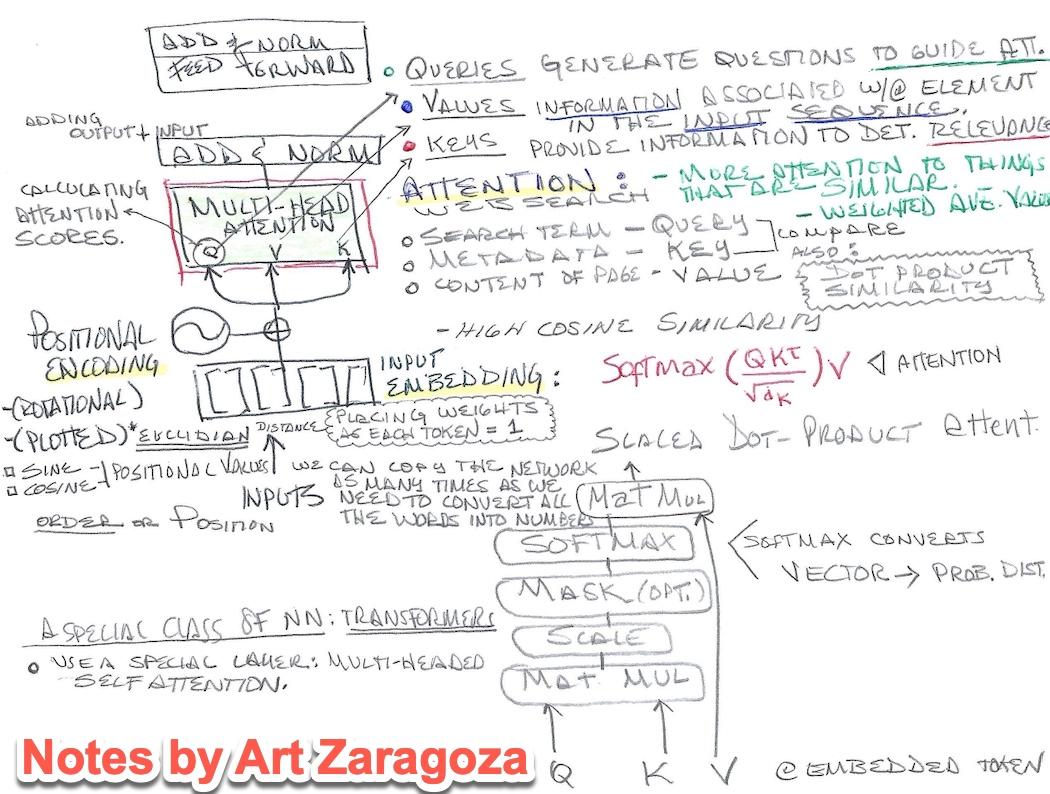

Attention Score Calculations

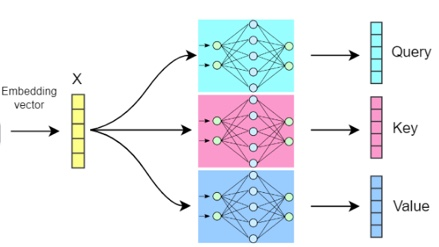

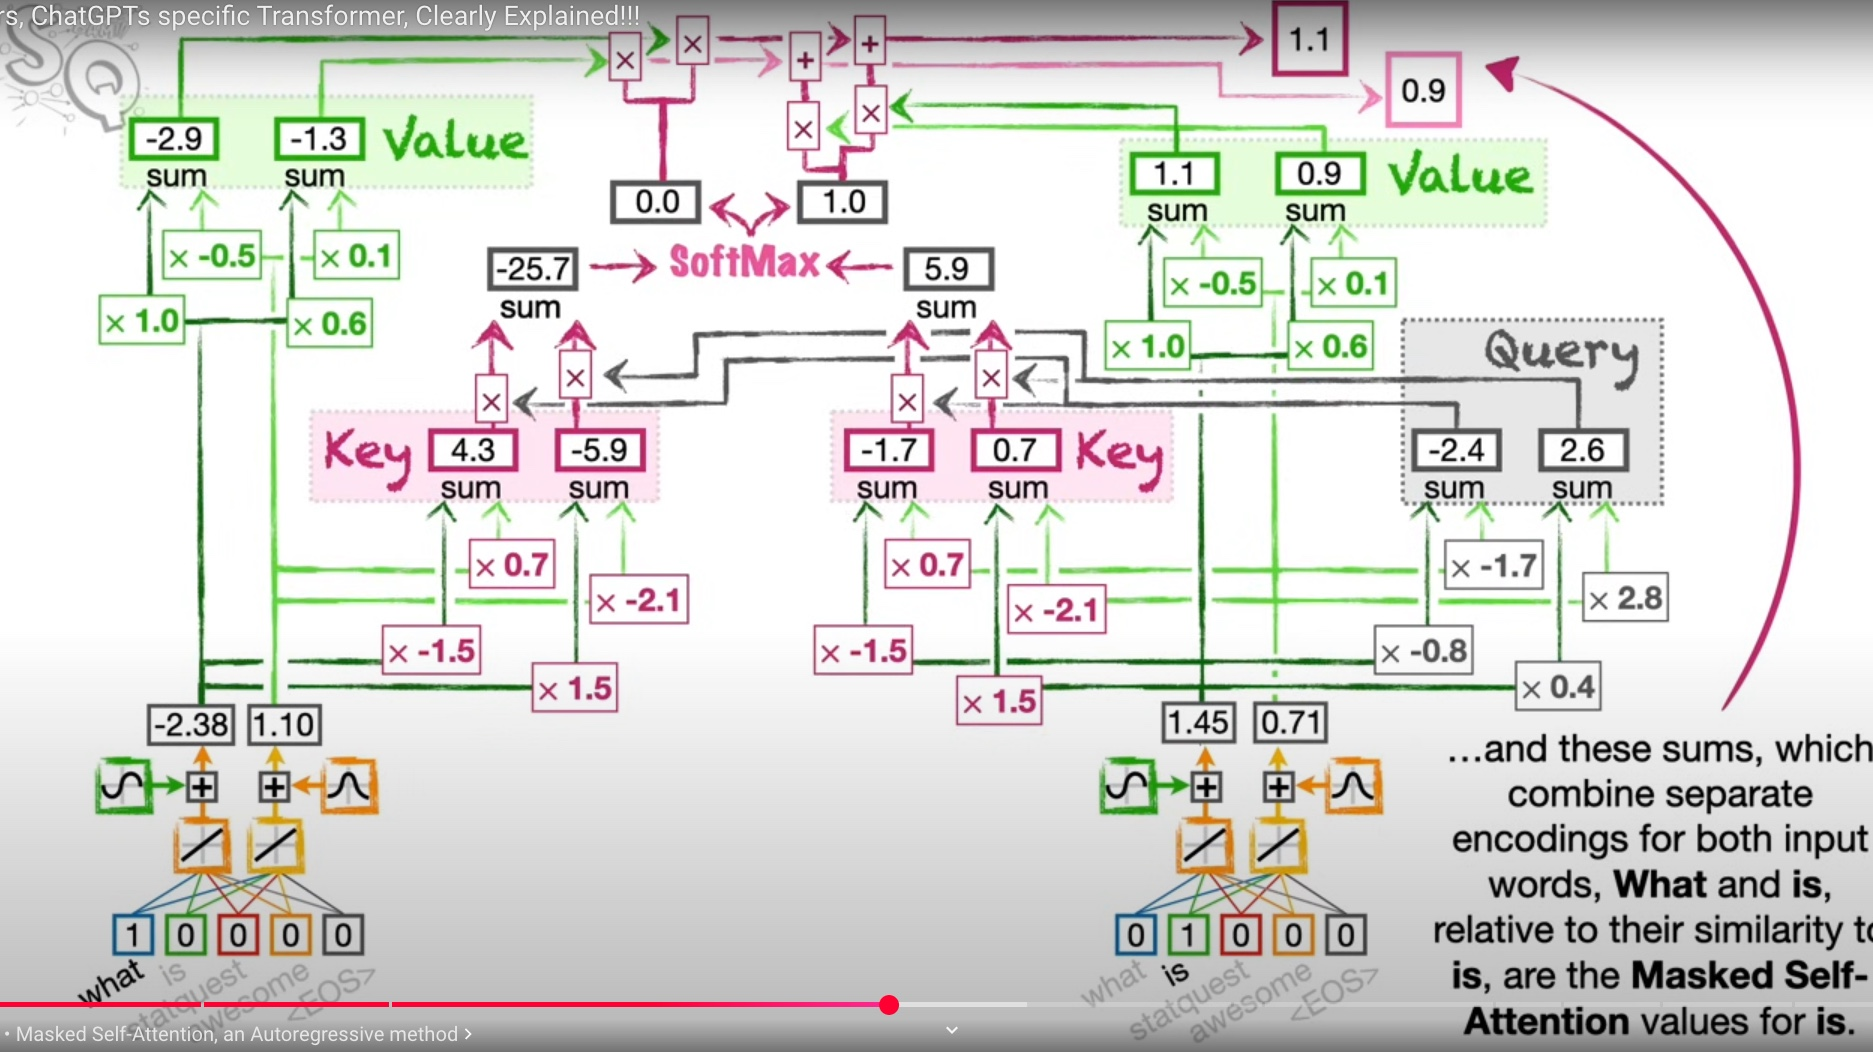

Input Embedding Decoder and Encoder Transformer

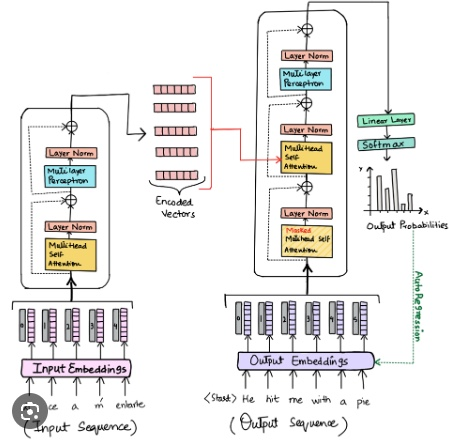

### Model 3 - Sentence Transformer Model Set up

Defining the Model

In [ ]:
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2') # Defining the model for text classification, semantic search and sentiment analysis.

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Encoding the Dataset

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # Setting the device to GPU if available, else CPU

In [ ]:
# Encoding the dataset splits with the Transformer Model
start = time.time()

X_train_st = model.encode(X_train["News"].values, show_progress_bar=True, device=device) # Apply Sentence Transformer on 'News' column for the Training set.
X_val_st = model.encode(X_val["News"].values, show_progress_bar=True, device=device)     # Apply Sentence Transformer on 'News' column for the Validation set.
X_test_st = model.encode(X_test["News"].values, show_progress_bar=True, device=device)   # Apply Sentence Transformer on 'News' column for the Test set.

end = time.time()
print(f'Time taken using a Transformer \033[1m{end - start:.6f} seconds.') # Rounded to 6 significant digits.

Batches:   0%|          | 0/9 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Time taken using a Transformer 0.697369 seconds.


Observations:
- Notice the processing time for these encodings was very fast, less than a second.

In [ ]:
print('For our Transformer model:\n', X_train_st.shape,'train split\n', X_val_st.shape,'validation split\n', X_test_st.shape,'test split\n') # Train-Validatio-Test Splits

For our Transformer model:
 (286, 384) train split
 (21, 384) validation split
 (42, 384) test split



Observations:
- Notice the News vector dimentionality for this Transformer Model is [384].

## **Sentiment Analysis - - - - -**

### Model Evaluation Criterion

For each Model we will look for:
- <font color=orange>**Accuracy and F1 Scores** </font>from Sentiment Predictions (Labels) by measuring the Confusion Matrix for each model and compare them.
- <font color=orange>**Computational Cost:** </font>Consider the time and resources required to train and use each model. We can compare processing times for each model and compare them.
- I will select the <font color=orange>**same Classifier** </font>when comparing all 3 models.
- We could run <font color=orange>**more extensive training**</font>, (Colab permitting) by trying each of the following classifiers:
   - GradientBoostingClassifier
   - RandomForestClassifier
   - DecisionTreeClassifier

# We Need to Consider these factors:

- Vector Size: While not the sole determinant, larger vectors (like Transformer's 384) can potentially capture more complex relationships but may also be computationally more expensive.
- Training Data: The quality and size of the data used to train each model significantly impacts performance.


Summary of the tradeoffs using each of the three classifiers with each of our models:  Attention is All You Need ;-)

<table border="1">
  <thead>
    <tr>
      <th>Model</th>
      <th>Classifier</th>
      <th>Strengths</th>
      <th>Weaknesses</th>
      <th>GPU Requirements</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>word2vec</td>
      <td>GradientBoostingClassifier</td>
      <td>Captures semantic meaning well; enhances feature representation for structured data.</td>
      <td>May not capture rare word dependencies as effectively.</td>
      <td>1</td>
    </tr>
    <tr>
      <td>word2vec</td>
      <td>RandomForestClassifier</td>
      <td>Embedding adds rich word relationships to the classifier, improving performance on text-based data.</td>
      <td>Can lead to overfitting if embeddings are not regularized.</td>
      <td>1</td>
    </tr>
    <tr>
      <td>word2vec</td>
      <td>DecisionTreeClassifier</td>
      <td>Simple, interpretable results based on word similarity and context.</td>
      <td>Word2vec's continuous vector representation may be too complex for a decision tree to interpret well.</td>
      <td>1</td>
    </tr>
    <tr>
      <td>GloVe</td>
      <td>GradientBoostingClassifier</td>
      <td>GloVe captures global relationships between words, enhancing predictive power for text classification.</td>
      <td>Poor performance with rare or out-of-vocabulary terms, potentially reducing accuracy.</td>
      <td>1</td>
    </tr>
    <tr>
      <td>GloVe</td>
      <td>RandomForestClassifier</td>
      <td>Global co-occurrence statistics improve decision boundaries in a structured manner.</td>
      <td>Embedding dimensionality can lead to overfitting in random forests.</td>
      <td>1</td>
    </tr>
    <tr>
      <td>GloVe</td>
      <td>DecisionTreeClassifier</td>
      <td>Offers interpretable, meaningful splits based on word co-occurrence.</td>
      <td>Limited performance if embeddings don't represent very specific or nuanced features.</td>
      <td>1</td>
    </tr>
    <tr>
      <td>Transformer</td>
      <td>GradientBoostingClassifier</td>
      <td>Captures long-range dependencies and context effectively, boosting performance on sequential tasks.</td>
      <td>High computational costs, slow training times.</td>
      <td>3</td>
    </tr>
    <tr>
      <td>Transformer</td>
      <td>RandomForestClassifier</td>
      <td>Transformer embeddings can capture rich, contextual relationships, enhancing performance.</td>
      <td>Difficulty handling large embeddings; may be computationally expensive for large datasets.</td>
      <td>2</td>
    </tr>
    <tr>
      <td>Transformer</td>
      <td>DecisionTreeClassifier</td>
      <td>Transformer embeddings allow more complex splits based on context, improving decision tree results.</td>
      <td>Decision trees may struggle with the complexity of transformer embeddings leading to inefficiency.</td>
      <td>2</td>
    </tr>
  </tbody>
</table>

### Utility Functions

In [ ]:
def plot_confusion_matrix(model, predictors, target):
    """
    Plot a confusion matrix to visualize the performance of a classification model.

    Parameters:
    actual (array-like): The true labels.
    predicted (array-like): The predicted labels from the model.

    Returns:
    None: Displays the confusion matrix plot.
    """
    pred = model.predict(predictors)  # Make predictions using the classifier.

    cm = confusion_matrix(target, pred)  # Compute the confusion matrix.

    plt.figure(figsize=(5, 4))  # Create a new figure with a specified size.
    label_list = [0, 1,-1]  # Define the labels for the confusion matrix.
    sns.heatmap(cm, annot=True, fmt='.0f', cmap='Blues', xticklabels=label_list, yticklabels=label_list)
    # Plot the confusion matrix using a heatmap with annotations.

    plt.ylabel('Actual')  # Label for the y-axis.
    plt.xlabel('Predicted')  # Label for the x-axis.
    plt.title('Confusion Matrix')  # Title of the plot.
    plt.show()  # Display the plot.

In [ ]:
def model_performance_classification_sklearn(model, predictors, target):
    """
    Compute various performance metrics for a classification model using sklearn.

    Parameters:
    model (sklearn classifier): The classification model to evaluate.
    predictors (array-like): The independent variables used for predictions.
    target (array-like): The true labels for the dependent variable.

    Returns:
    pandas.DataFrame: A DataFrame containing the computed metrics (Accuracy, Recall, Precision, F1-score).
    """
    pred = model.predict(predictors)  # Make predictions using the classifier.

    acc = accuracy_score(target, pred)  # Compute Accuracy.
    recall = recall_score(target, pred,average='weighted')  # Compute Recall.
    precision = precision_score(target, pred,average='weighted')  # Compute Precision.
    f1 = f1_score(target, pred,average='weighted')  # Compute F1-score.

    # Create a DataFrame to store the computed metrics.
    df_perf = pd.DataFrame(
        {
            "Accuracy": [acc],
            "Recall": [recall],
            "Precision": [precision],
            "F1": [f1],
        }
    )

    return df_perf  # Return the DataFrame with the metrics.

### Model 1 - Not Tuned (base) - Word2Vec Model

In [ ]:
# Building the model

#Uncomment only one of the snippets related to fitting the model to the data

#base_wv = GradientBoostingClassifier(random_state = 42)
#base_wv = RandomForestClassifier(random_state=42)
base_wv = DecisionTreeClassifier(random_state=42)

# Fitting on train data
base_wv.fit(X_train_wv, y_train)

DecisionTreeClassifier(random_state=42)

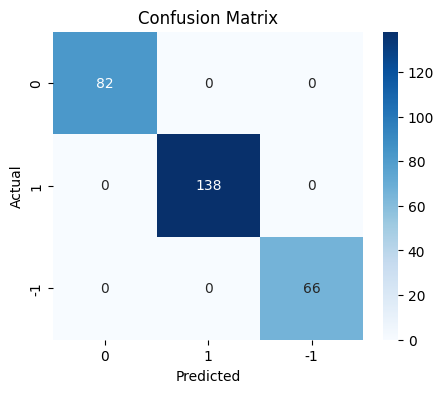

In [ ]:
plot_confusion_matrix(base_wv,X_train_wv,y_train) # Training

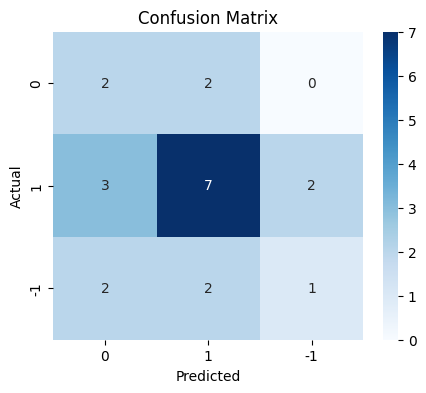

In [ ]:
plot_confusion_matrix(base_wv,X_val_wv,y_val) # Validation

In [ ]:
# Calculating different metrics on training data
base_train_wv = model_performance_classification_sklearn(base_wv,X_train_wv,y_train)
print("Training performance:\n", base_train_wv)

Training performance:
    Accuracy  Recall  Precision   F1
0      1.00    1.00       1.00 1.00


In [ ]:
# Calculating different metrics on validation data
base_val_wv = model_performance_classification_sklearn(base_wv,X_val_wv,y_val)
print("Validation performance:\n",base_val_wv)

Validation performance:
    Accuracy  Recall  Precision   F1
0      0.48    0.48       0.50 0.48


Observations:
- Despite the training with 95% of the data, the Validation set is giving us an overfit situation.

### Model 2 - Not Tuned (base) - GloVe Model

In [ ]:
#Building the model

#Uncomment only one of the snippets related to fitting the model to the data

#base_wv = GradientBoostingClassifier(random_state = 42)
#base_wv = RandomForestClassifier(random_state=42)
base_gl = DecisionTreeClassifier(random_state=42)

# Fitting on train data
base_gl.fit(X_train_gl, y_train) #Complete the code to fit the chosen model on the train data

DecisionTreeClassifier(random_state=42)

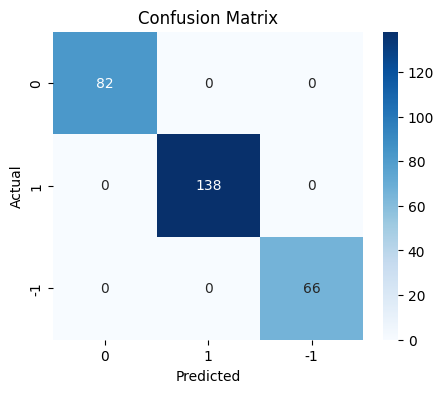

In [ ]:
plot_confusion_matrix(base_gl,X_train_gl,y_train) # Confusion matrix for the train data on GloVe

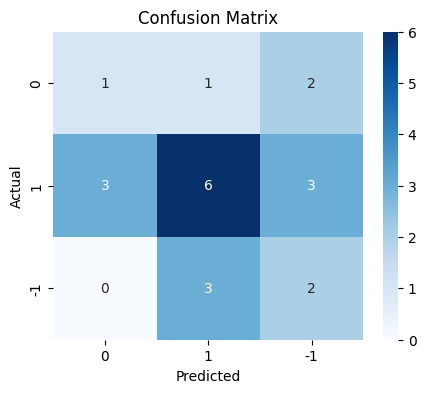

In [ ]:
plot_confusion_matrix(base_gl,X_val_gl,y_val) # Confusion matrix for the validation data on GloVe

In [ ]:
#Calculating different metrics on training data
base_train_gl=model_performance_classification_sklearn(base_gl,X_train_gl,y_train) # Calculate model performance for the training data on a GloVe Model
print("Training performance:\n", base_train_gl)

Training performance:
    Accuracy  Recall  Precision   F1
0      1.00    1.00       1.00 1.00


In [ ]:
#Calculating different metrics on validation data
base_val_gl = model_performance_classification_sklearn(base_gl,X_val_gl,y_val) # Calculate model performance for the validation data on a GloVe model.
print("Validation performance:\n",base_val_gl)

Validation performance:
    Accuracy  Recall  Precision   F1
0      0.43    0.43       0.46 0.44


Observations:
- Overfit situation with the Validation set.
- Slightly worse performance metrics conpared to Word2Vec

### Model 3 - Not Tuned (base) - Sentence Transformer Model

In [ ]:
# Building the model

#Uncomment only one of the snippets related to fitting the model to the data

#base_wv = GradientBoostingClassifier(random_state = 42)
#base_wv = RandomForestClassifier(random_state=42)
base_st = DecisionTreeClassifier(random_state=42)

# Fitting on train data
base_st.fit(X_train_st, y_train) #Complete the code to fit the chosen model on the train data

DecisionTreeClassifier(random_state=42)

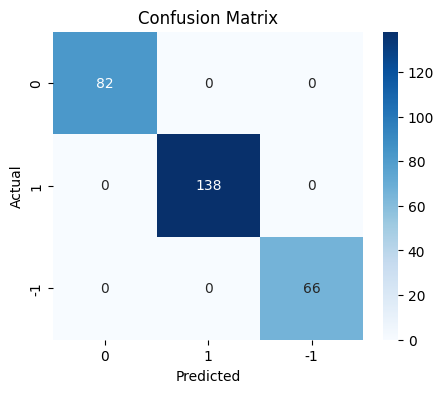

In [ ]:
plot_confusion_matrix(base_st,X_train_st,y_train) # Confusion matrix for the train data on our Transformer model.

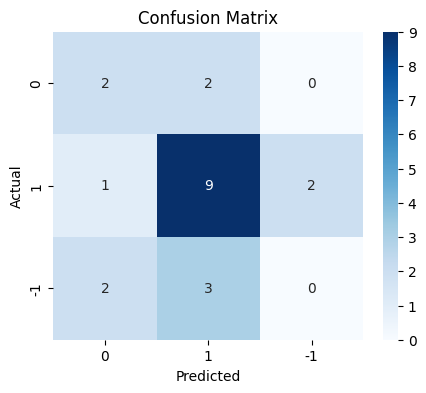

In [ ]:
plot_confusion_matrix(base_st,X_val_st,y_val) # Confusion matrix for the validation data on our Transformer model.

In [ ]:
#Calculating different metrics on training data
base_train_st=model_performance_classification_sklearn(base_st,X_train_st,y_train) # Model performance for the training data on our Transformer Model.
print("Training performance:\n", base_train_st)

Training performance:
    Accuracy  Recall  Precision   F1
0      1.00    1.00       1.00 1.00


In [ ]:
#Calculating different metrics on validation data
base_val_st = model_performance_classification_sklearn(base_st,X_val_st,y_val)  # Model performance for the validation data on our Transformer Model.
print("Validation performance:\n",base_val_st)

Validation performance:
    Accuracy  Recall  Precision   F1
0      0.52    0.52       0.44 0.48


Observations:
- The best performance metrics of the three models on validation set.
- However, the numbers remain too low.
- Transformer was pretty darn fast when processing.
- Accuracy  Recall  Precision   F1
  0.52      0.52    0.44        0.48

### Tuned Model 1 - Word2Vec Model

**Note**: The parameter grid provided below is a sample grid. It can be modified depending on the compute power of the system being used.

In [ ]:
start = time.time()

# Choose the type of classifier.

#Uncomment only one of the snippets corrrsponding to the base model trained previously

#tuned_wv = GradientBoostingClassifier(random_state = 42)
#tuned_wv = RandomForestClassifier(random_state=42)
tuned_wv = DecisionTreeClassifier(random_state=42)


parameters = {
    'max_depth': np.arange(3,7),
    'min_samples_split': np.arange(5,12,2),
    'max_features': ['log2', 'sqrt', 0.2, 0.4]
}

# Run the grid search
grid_obj = GridSearchCV(tuned_wv, parameters, scoring='f1_weighted',cv=5,n_jobs=-1)
grid_obj = grid_obj.fit(X_train_wv, y_train)

end = time.time()
print("Time taken ",(end-start))

# Set the clf to the best combination of parameters
tuned_wv = grid_obj.best_estimator_

Time taken  6.90865159034729


<h2>Decision Tree Classifier Tuning Parameters</h2>

<table>
  <tr>
    <th>Parameter</th>
    <th>Description</th>
    <th>Values</th>
  </tr>
  <tr>
    <td>max_depth</td>
    <td>Maximum depth of the tree</td>
    <td>[3, 4, 5, 6]</td>
  </tr>
  <tr>
    <td>min_samples_split</td>
    <td>Minimum number of samples required to split an internal node</td>
    <td>[5, 7, 9, 11]</td>
  </tr>
  <tr>
    <td>max_features</td>
    <td>Number of features considered when splitting a node</td>
    <td>['log2', 'sqrt', 0.2, 0.4]</td>
  </tr>
</table>

</body>
</html>

In [ ]:
# Fit the best algorithm to the data.
tuned_wv.fit(X_train_wv, y_train)

DecisionTreeClassifier(max_depth=6, max_features='sqrt', min_samples_split=5,
                       random_state=42)

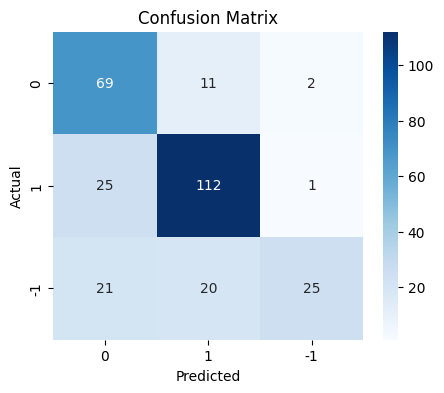

In [ ]:
plot_confusion_matrix(tuned_wv,X_train_wv,y_train)

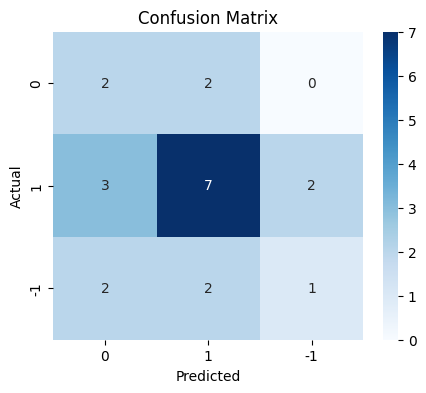

In [ ]:
plot_confusion_matrix(tuned_wv,X_val_wv,y_val)

In [ ]:
#Calculating different metrics on training data
tuned_train_wv=model_performance_classification_sklearn(tuned_wv,X_train_wv,y_train)
print("Training performance:\n",tuned_train_wv)

Training performance:
    Accuracy  Recall  Precision   F1
0      0.72    0.72       0.76 0.71


In [ ]:
#Calculating different metrics on validation data
tuned_val_wv = model_performance_classification_sklearn(tuned_wv,X_val_wv,y_val)
print("Validation performance:\n",tuned_val_wv)

Validation performance:
    Accuracy  Recall  Precision   F1
0      0.48    0.48       0.50 0.48


### Tuned Model 2 - GloVe Model

In [ ]:
start = time.time()

#Uncomment only one of the snippets corrrsponding to the base model trained previously

#tuned_wv = GradientBoostingClassifier(random_state = 42)
#tuned_wv = RandomForestClassifier(random_state=42)
tuned_gl = DecisionTreeClassifier(random_state=42)

parameters = {
    'max_depth': np.arange(3,7),
    'min_samples_split': np.arange(5,12,2),
    'max_features': ['log2', 'sqrt', 0.2, 0.4]
}

# Run the grid search
grid_obj = GridSearchCV(tuned_gl, parameters, scoring='f1_weighted',cv=5,n_jobs=-1) #Complete the code to pass the chosen model
grid_obj = grid_obj.fit(X_train_gl, y_train)

end = time.time()
print("Time taken ",(end-start))

# Set the clf to the best combination of parameters
tuned_gl = grid_obj.best_estimator_

Time taken  2.4269731044769287


<h2>Decision Tree Classifier Tuning Parameters</h2>

<table>
  <tr>
    <th>Parameter</th>
    <th>Description</th>
    <th>Values</th>
  </tr>
  <tr>
    <td>max_depth</td>
    <td>Maximum depth of the tree</td>
    <td>[3, 4, 5, 6]</td>
  </tr>
  <tr>
    <td>min_samples_split</td>
    <td>Minimum number of samples required to split an internal node</td>
    <td>[5, 7, 9, 11]</td>
  </tr>
  <tr>
    <td>max_features</td>
    <td>Number of features considered when splitting a node</td>
    <td>['log2', 'sqrt', 0.2, 0.4]</td>
  </tr>
</table>

</body>
</html>

In [ ]:
# Fit the best algorithm to the data.
tuned_gl.fit(X_train_gl, y_train) # Fit the chosen model on the train data

DecisionTreeClassifier(max_depth=4, max_features='log2', min_samples_split=5,
                       random_state=42)

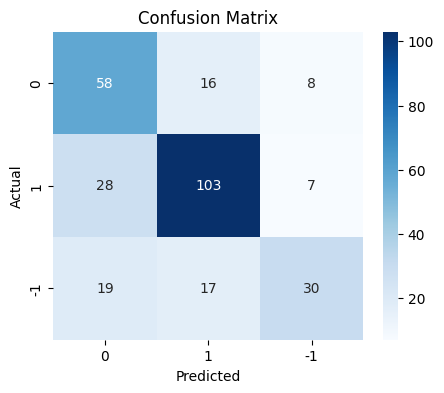

In [ ]:
plot_confusion_matrix(tuned_gl,X_train_gl, y_train) # Confusion matrix for the train data

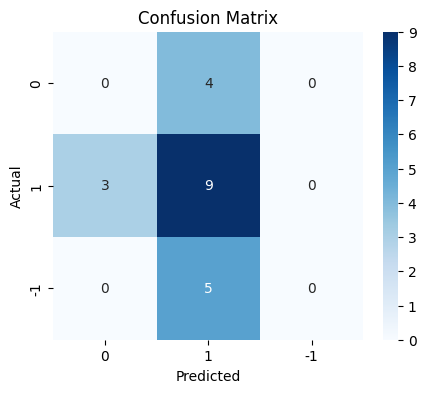

In [ ]:
plot_confusion_matrix(tuned_gl,X_val_gl,y_val) # Confusion matrix for the validation data

In [ ]:
# Metrics on training data
tuned_train_gl=model_performance_classification_sklearn(tuned_gl,X_train_gl, y_train) # Model performance for the training data on GloVe model.
print("Training performance:\n",tuned_train_gl)

Training performance:
    Accuracy  Recall  Precision   F1
0      0.67    0.67       0.68 0.67


In [ ]:
#Calculating different metrics on validation data
tuned_val_gl = model_performance_classification_sklearn(tuned_gl,X_val_gl,y_val) # Model performance for the validation data on GloVe model.
print("Validation performance:\n",tuned_val_gl)

Validation performance:
    Accuracy  Recall  Precision   F1
0      0.43    0.43       0.29 0.34


### Tuned Model 3 - Sentence Transformer Model

In [ ]:
start = time.time()

# Choose the type of classifier.

#Uncomment only one of the snippets corrrsponding to the base model trained previously

#tuned_wv = GradientBoostingClassifier(random_state = 42)
#tuned_wv = RandomForestClassifier(random_state=42)
tuned_st = DecisionTreeClassifier(random_state=42)

parameters = {
    'max_depth': np.arange(3,7),
    'min_samples_split': np.arange(5,12,2),
    'max_features': ['log2', 'sqrt', 0.2, 0.4]
}

# Run the grid search
grid_obj = GridSearchCV(tuned_st, parameters, scoring='f1_weighted',cv=5,n_jobs=-1) #Complete the code to pass the chosen model
grid_obj = grid_obj.fit(X_train_st, y_train)

end = time.time()
print("Time taken ",(end-start))

# Set the clf to the best combination of parameters
tuned_st = grid_obj.best_estimator_

Time taken  4.361521244049072


<h2>Decision Tree Classifier Tuning Parameters</h2>

<table>
  <tr>
    <th>Parameter</th>
    <th>Description</th>
    <th>Values</th>
  </tr>
  <tr>
    <td>max_depth</td>
    <td>Maximum depth of the tree</td>
    <td>[3, 4, 5, 6]</td>
  </tr>
  <tr>
    <td>min_samples_split</td>
    <td>Minimum number of samples required to split an internal node</td>
    <td>[5, 7, 9, 11]</td>
  </tr>
  <tr>
    <td>max_features</td>
    <td>Number of features considered when splitting a node</td>
    <td>['log2', 'sqrt', 0.2, 0.4]</td>
  </tr>
</table>

</body>
</html>

In [ ]:
# Fit the best algorithm to the data.
tuned_st.fit(X_train_st, y_train) #Complete the code to fit the chosen model on the train data

DecisionTreeClassifier(max_depth=6, max_features='log2', min_samples_split=7,
                       random_state=42)

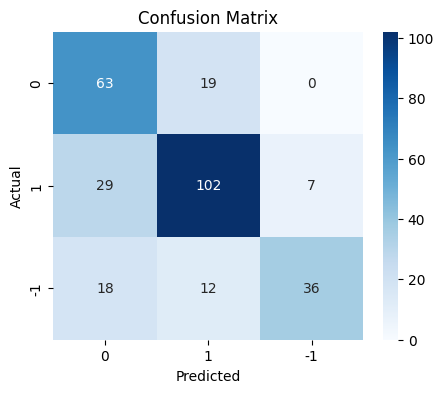

In [ ]:
plot_confusion_matrix(tuned_st,X_train_st,y_train) #Complete the code to plot the confusion matrix for the train data

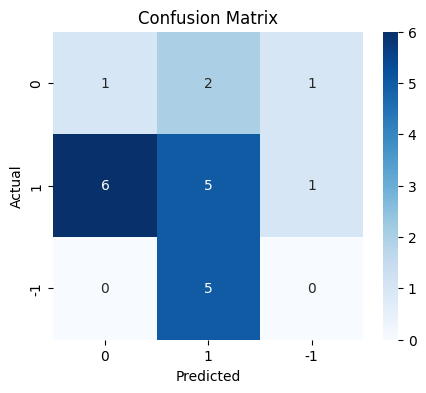

In [ ]:
plot_confusion_matrix(tuned_st,X_val_st,y_val) #Complete the code to plot the confusion matrix for the validation data

In [ ]:
# Metrics on training data
tuned_train_st=model_performance_classification_sklearn(tuned_st,X_train_st,y_train) #C Model performance for the training data
print("Training performance:\n",tuned_train_st)

Training performance:
    Accuracy  Recall  Precision   F1
0      0.70    0.70       0.73 0.70


In [ ]:
# Metrics on validation data
tuned_val_st = model_performance_classification_sklearn(tuned_st,X_val_st,y_val) # Model performance for the validation data
print("Validation performance:\n",tuned_val_st)

Validation performance:
    Accuracy  Recall  Precision   F1
0      0.29    0.29       0.27 0.27


### Model Performance Summary and Final Model Selection

In [ ]:
#training performance comparison

models_train_comp_df = pd.concat(
    [base_train_wv.T,
     base_train_gl.T,
     base_train_st.T,
     tuned_train_wv.T,
     tuned_train_gl.T,
     tuned_train_st.T,
    ],axis=1
)

models_train_comp_df.columns = [
    "Base Model (Word2Vec)",
    "Base Model (GloVe)",
    "Base Model (Sentence Transformer)",
    "Tuned Model (Word2Vec)",
    "Tuned Model (GloVe)",
    "Tuned Model (Sentence Transformer)",
]

print("Training performance comparison:")
models_train_comp_df

Training performance comparison:


Base Model (Word2Vec)  Base Model (GloVe)  \
Accuracy                    1.00                1.00   
Recall                      1.00                1.00   
Precision                   1.00                1.00   
F1                          1.00                1.00   

           Base Model (Sentence Transformer)  Tuned Model (Word2Vec)  \
Accuracy                                1.00                    0.72   
Recall                                  1.00                    0.72   
Precision                               1.00                    0.76   
F1                                      1.00                    0.71   

           Tuned Model (GloVe)  Tuned Model (Sentence Transformer)  
Accuracy                  0.67                                0.70  
Recall                    0.67                                0.70  
Precision                 0.68                                0.73  
F1                        0.67                                0.70

In [ ]:
# Validation performance comparison

models_val_comp_df = pd.concat(
    [base_val_wv.T,
     base_val_gl.T,
     base_val_st.T,
     tuned_val_wv.T,
     tuned_val_gl.T,
     tuned_val_st.T,
     ],axis=1
)

models_val_comp_df.columns = [
    "Base Model (Word2Vec)",
    "Base Model (GloVe)",
    "Base Model (Sentence Transformer)",
    "Tuned Model (Word2Vec)",
    "Tuned Model (GloVe)",
    "Tuned Model (Sentence Transformer)",
]

print("Validation performance comparison:")
models_val_comp_df

Validation performance comparison:


Base Model (Word2Vec)  Base Model (GloVe)  \
Accuracy                    0.48                0.43   
Recall                      0.48                0.43   
Precision                   0.50                0.46   
F1                          0.48                0.44   

           Base Model (Sentence Transformer)  Tuned Model (Word2Vec)  \
Accuracy                                0.52                    0.48   
Recall                                  0.52                    0.48   
Precision                               0.44                    0.50   
F1                                      0.48                    0.48   

           Tuned Model (GloVe)  Tuned Model (Sentence Transformer)  
Accuracy                  0.43                                0.29  
Recall                    0.43                                0.29  
Precision                 0.29                                0.27  
F1                        0.34                                0.27

<font size=6 color='#87CEFA'>Best Model Selection:</font>



  <ul>
    <li><font size=3 color='#87CEFA'>Tuning the model Word2Vec with a Decision Tree Classifier give us comparable performance metrics as using a non-tuned Sentence Transformer Model:</li></font>
  </ul>

  <table>
    <tr>
      <th>Model</th>
      <th>Accuracy</th>
      <th>F1-Score</th>
    </tr>
    <tr>
      <td>Tuned Word2Vec</td>
      <td>0.48</td>
      <td>0.48</td>
    </tr>
    <tr>
      <td>Non-Tuned Sentence Transformer</td>
      <td>0.52</td>
      <td>0.48</td>
    </tr>
  </table>

  <ul>
    <li><font size=3 color='#87CEFA'>However, the TPU/GPU processing is much higher so for cost considerations. Word2Vec may be more economical.</li></font>
  </ul>

</body>
</html>

### ================>>>>>>>   Model Performance Check on Test Data - - - Drum roll please... ;-)    <<<<<<

In [ ]:
# Fit the best model to the test data.
tuned_wv.fit(X_test_wv, y_test) # Fit the chosen model on the test data.

DecisionTreeClassifier(random_state=42)

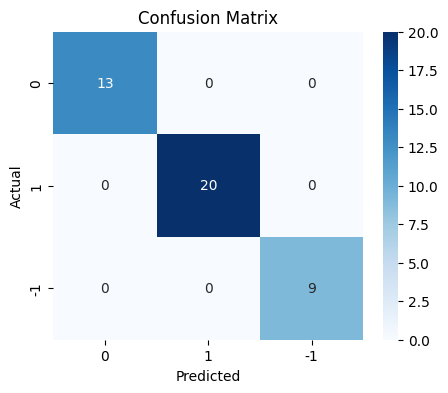

In [ ]:
plot_confusion_matrix(tuned_wv,X_test_wv,y_test) # Confusion matrix for the final model and test data.

In [ ]:
# Calculating different metrics on test data
final_model_test = model_performance_classification_sklearn(tuned_wv,X_test_wv,y_test) # Final model's performance with the test data.
print("Test performance for the final model:\n",final_model_test)

Test performance for the final model:
    Accuracy  Recall  Precision   F1
0      1.00    1.00       1.00 1.00


<font size=6 color='orange'> Final Model Selection Observations:</font>

-  <font color=orange> **Outstanding results !!**
- Model selected: Tuned Word2Vec model processing the test data.
- Performance Metrics on Test set for Accuracy and F1 were 100%.
- Processing time was nearly 7 seconds during training, other models were faster but less accurate. </font>

## **Weekly News Summarization** - Second Part of the LLM Project

**Important Note**: It is recommended to run this section of the project independently from the previous sections in order to avoid runtime crashes due to RAM overload.

#### Installing and Importing the necessary libraries

In [ ]:
# It installs version 0.1.85 of the GPU llama-cpp-python library
!CMAKE_ARGS="-DLLAMA_CUBLAS=on" FORCE_CMAKE=1 pip install llama-cpp-python==0.1.85 --force-reinstall --no-cache-dir -q # Invoked as a shell command executed within Jupyter/Google Colab.

# Installation for CPU llama-cpp-python
# uncomment and run the following code in case GPU is not being used
#!CMAKE_ARGS="-DLLAMA_CUBLAS=off" FORCE_CMAKE=1 pip install llama-cpp-python==0.1.85 --force-reinstall --no-cache-dir -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 24.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 121.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 239.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 88.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cupy-cuda12x 12.2.0 requires numpy<1.27,>=1.20, but you have numpy 2.2.1 which is incompatible.
gensim 4.3.3 requires numpy<2.0,>=1.18.5, but you have numpy 2.2.1 which is incompatible.
langchain 0.3.14 requires numpy<2,>=1.22.4; python_version < "3.12", but you have numpy 2.2.1 which is incompatible.
numba 0.60.0 requires numpy<2.1,>=1.22, but you have numpy 2.2.1 wh

NOTE: I previously removed these incompatibility versions and set the older versions of numpy and python. Most of the errors were removed. However, I prefer to keep using the latest versions whenever possible as a goal.  
- I have not notice problems after these errors due to older version requested.

The meaning of the CMAKE_ARGS="-DLLAMA_CUBLAS=on" flag settings:

	•	CMAKE_ARGS: Environment variable passed to the build system (CMake).
	•	-DLLAMA_CUBLAS=on: A flag to enable CUDA BLAS (cuBLAS) support for Llama models.
	•	cuBLAS is an NVIDIA library optimized for GPU-based matrix operations, which speeds up computations when using NVIDIA GPUs.

#### Downloading the model Llama from huggingface

In [ ]:
%%time
from huggingface_hub import hf_hub_download          # Function to download the model from the Hugging Face model hub
from llama_cpp import Llama                          # Importing the Llama class from the llama_cpp module
import pandas as pd                                  # Importing the library for data manipulation
from tqdm import tqdm                                # For progress bar related functionalities
tqdm.pandas()

CPU times: user 1.66 ms, sys: 72 µs, total: 1.73 ms
Wall time: 4.01 ms


#### Loading the data

In [ ]:
stock_news = pd.read_csv("/content/stock_news.csv") # Load the dataset

In [ ]:
data = stock_news.copy()                            # Make a dtaframe copy for analysis

In [ ]:
data.info(verbose=True)                             # Get details on the data, datatype, shape, memory usage.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 349 entries, 0 to 348
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    349 non-null    object 
 1   News    349 non-null    object 
 2   Open    349 non-null    float64
 3   High    349 non-null    float64
 4   Low     349 non-null    float64
 5   Close   349 non-null    float64
 6   Volume  349 non-null    int64  
 7   Label   349 non-null    int64  
dtypes: float64(4), int64(2), object(2)
memory usage: 21.9+ KB


Observations:
- Date and News are object datatypse and will need handling

#### Wordcount to check on tokens

In [ ]:
# Wordcount of a text in a file named stock_news
# Helpful to determine tokens-range to specify the "context window" parameter attribute of the instantiated class holding the model.
import re

def word_count(filepath):
  """Counts the number of words in a text file.

  Args:
    filepath: The path to the text file.

  Returns:
    The number of words in the file, or -1 if the file does not exist.
  """
  try:
    with open(filepath, 'r') as file:
      text = file.read()
      words = re.findall(r'\b\w+\b', text.lower()) #Find all words, convert to lower case
      return len(words)
  except FileNotFoundError:
    return -1

word_count_result = word_count("stock_news.csv") # Replace with the actual file name

if word_count_result != -1:
  print("Total word count:", word_count_result)
else:
  print("File not found.")

Total word count: 22144


Observations:
- To properly configure the model's parameters, particularly the context window size (n_ctx), we need to count the total number of words in the text. This helps determine the optimal setting for the maximum number of tokens the model can process at once, such as setting n_ctx to 4500.

#### Loading the model

NOTE:
- We will use the downloaded Huggingface model for our purposes.
- HF Token for User Acces has been set for authentication.

In [ ]:
model_name_or_path = "TheBloke/Mistral-7B-Instruct-v0.2-GGUF"  # Model path
model_basename = "mistral-7b-instruct-v0.2.Q6_K.gguf"          # Model name

model_path = hf_hub_download(                                  # Download the little model with 7.3 billion parameters
    repo_id="TheBloke/Mistral-7B-Instruct-v0.2-GGUF",          # Use the repo_id
    filename="mistral-7b-instruct-v0.2.Q6_K.gguf"              # Use this filename
)                                                              # Examine progress (blue) until completion (green)

mistral-7b-instruct-v0.2.Q6_K.gguf:   0%|          | 0.00/5.94G [00:00<?, ?B/s]

#### Connect downloaded model to execute runtime on available GPUs

In [ ]:
# Connect runtime to GPU, a number of layers will be offloaded to the GPU for computations.
llm = Llama(                                                   # Variable that will hold the instance of the Llama model. Llama is the instantiated class of the llama-cpp-python lybrary.
    model_path=model_path,                                     # Path to the model, previously defined. This is typically a .bin file that contains the trained weights of the model.
    n_gpu_layers=100,                                          # Number of layers transferred to GPU. Which ones will be listed as an output.
    n_ctx=4500,                                                # Context window. It determines how much text (in tokens) the model can process or “remember” in a single pass.
)

AVX = 1 | AVX2 = 1 | AVX512 = 0 | AVX512_VBMI = 0 | AVX512_VNNI = 0 | FMA = 1 | NEON = 0 | ARM_FMA = 0 | F16C = 1 | FP16_VA = 0 | WASM_SIMD = 0 | BLAS = 1 | SSE3 = 1 | SSSE3 = 1 | VSX = 0 | 


Observations:

<h2>Instruction Set Availability with the the Llama model loaded above:</h2>

<table>
    <thead>
        <tr>
            <th>Instruction Set</th>
            <th>Availability</th>
            <th>Description</th>
        </tr>
    </thead>
    <tbody>
        <tr>
            <td>AVX</td>
            <td class="highlight">1</td>
            <td>Advanced Vector Extensions (AVX) for fast floating-point math</td>
        </tr>
        <tr>
            <td>AVX2</td>
            <td class="highlight">1</td>
            <td>AVX2 for improved vectorization and SIMD (Single Instruction, Multiple Data)</td>
        </tr>
        <tr>
            <td>AVX512</td>
            <td>0</td>
            <td>AVX512 for even larger vector sizes (512-bit wide registers)</td>
        </tr>
        <tr>
            <td>AVX512_VBMI</td>
            <td>0</td>
            <td>AVX512_VBMI (AVX-512 Vector Byte Manipulation Instructions) for byte-level operations</td>
        </tr>
        <tr>
            <td>AVX512_VNNI</td>
            <td>0</td>
            <td>AVX512_VNNI (AVX-512 Vector Neural Network Instructions) for deep learning tasks</td>
        </tr>
        <tr>
            <td>FMA</td>
            <td class="highlight">1</td>
            <td>Fused Multiply-Add (FMA) for efficient floating-point operations</td>
        </tr>
        <tr>
            <td>NEON</td>
            <td>0</td>
            <td>NEON SIMD architecture for ARM-based systems (used for multimedia processing)</td>
        </tr>
        <tr>
            <td>ARM_FMA</td>
            <td>0</td>
            <td>ARM-specific FMA operations for ARM architecture</td>
        </tr>
        <tr>
            <td>F16C</td>
            <td class="highlight">1</td>
            <td>F16C support for half-precision floating-point calculations</td>
        </tr>
        <tr>
            <td>FP16_VA</td>
            <td>0</td>
            <td>FP16_VA for enhanced floating-point processing with 16-bit precision</td>
        </tr>
        <tr>
            <td>WASM_SIMD</td>
            <td>0</td>
            <td>WebAssembly SIMD (WASM_SIMD) support for SIMD in WebAssembly environments</td>
        </tr>
        <tr>
            <td>BLAS</td>
            <td class="highlight">1</td>
            <td>BLAS (Basic Linear Algebra Subprograms) for matrix operations</td>
        </tr>
        <tr>
            <td>SSE3</td>
            <td class="highlight">1</td>
            <td>SSE3 (Streaming SIMD Extensions 3) for 128-bit SIMD instructions</td>
        </tr>
        <tr>
            <td>SSSE3</td>
            <td class="highlight">1</td>
            <td>SSSE3 (Supplemental Streaming SIMD Extensions 3) for more efficient SIMD operations</td>
        </tr>
        <tr>
            <td>VSX</td>
            <td>0</td>
            <td>VSX (Vector Scalar Extensions) for vector and scalar operations in PowerPC architecture</td>
        </tr>
    </tbody>
</table>

</body>
</html>

NOTE:
- Nice article with good instructions on how to download this same Llama model and run it locally on your MacBook M1 Pro with 16GB RAM: [Run Mistral 7B on your Mac](https://medium.com/@mne/run-mistral-7b-model-on-macbook-m1-pro-with-16gb-ram-using-llama-cpp-44134694b773)

In [ ]:
# uncomment and run the following code in case GPU is not being used

# llm = Llama(
#     model_path=model_path,
#     n_ctx=4500, # Context window
#     n_cores=-2 # Number of CPU cores to use
# )

#### Aggregating the data weekly

In [ ]:
data["Date"] = pd.to_datetime(data['Date'])                                     # Convert the 'Date' column to datetime format.

In [ ]:
weekly_grouped = data.groupby(pd.Grouper(key='Date', freq='W'))                 # Group the data by week using the 'Date' column.

In [ ]:
weekly_grouped_full = weekly_grouped.apply(lambda x: x).reset_index(drop=True)  # Display all rows from the grouped Dataframe
print(weekly_grouped_full)

          Date                                               News  Open  High  \
0   2019-01-02   The tech sector experienced a significant dec... 41.74 42.24   
1   2019-01-02   Apple lowered its fiscal Q1 revenue guidance ... 41.74 42.24   
2   2019-01-02   Apple cut its fiscal first quarter revenue fo... 41.74 42.24   
3   2019-01-02   This news article reports that yields on long... 41.74 42.24   
4   2019-01-02   Apple's revenue warning led to a decline in U... 41.74 42.24   
..         ...                                                ...   ...   ...   
344 2019-04-30   Media mogul Oprah Winfrey, known for influenc... 50.76 50.85   
345 2019-04-30   European shares fell on Tuesday, with banks u... 50.76 50.85   
346 2019-04-30   This article reports that the S&P 500 reached... 50.76 50.85   
347 2019-04-30   The Federal Reserve is anticipated to keep in... 50.76 50.85   
348 2019-04-30   In the first quarter, South Korea's Samsung E... 50.76 50.85   

      Low  Close     Volume

In [ ]:
# Aggregate the "News" column with a '||' as a separator and their corresponding "Volume" and "Label" also separated by '||' and reset the index.
# weekly_grouped = data.groupby(pd.Grouper(key='Date', freq='W')) # Group the data by week using the 'Date' column.
weekly_aggregated = weekly_grouped.agg(
    {
        "News": lambda x: " || ".join(x),
        "Volume": lambda x: " || ".join(map(str, x)),  # Assuming 'Value' needs string conversion
        "Label": lambda x: " || ".join(map(str, x)),  # Assuming 'Label' needs string conversion
    }
).reset_index()
weekly_aggregated

Date                                               News  \
0  2019-01-06   The tech sector experienced a significant dec...   
1  2019-01-13   Sprint and Samsung plan to release 5G smartph...   
2  2019-01-20   The U.S. stock market declined on Monday as c...   
3  2019-01-27   The Swiss National Bank (SNB) governor, Andre...   
4  2019-02-03   Caterpillar Inc reported lower-than-expected ...   
5  2019-02-10   The Dow Jones Industrial Average, S&P 500, an...   
6  2019-02-17   This week, the European Union's second highes...   
7  2019-02-24   This news article discusses progress towards ...   
8  2019-03-03   The Dow Jones Industrial Average and other ma...   
9  2019-03-10   Spotify, the world's largest paid music strea...   
10 2019-03-17   The United States opposes France's digital se...   
11 2019-03-24   Facebook's stock price dropped more than 3% o...   
12 2019-03-31   This news article reports that the S&P 500 In...   
13 2019-04-07   Apple and other consumer brands, including LV...   
14 2019-04-14   In March, mobile phone shipments to China dro...   
15 2019-04-21   The chairman of Taiwan's Foxconn, Terry Gou, ...   
16 2019-04-28   Taiwan's export orders continued to decline f...   
17 2019-05-05   Spotify reported better-than-expected Q1 reve...   

                                               Volume  \
0   130672400 || 130672400 || 130672400 || 1306724...   
1   109012000 || 109012000 || 109012000 || 1090120...   
2   129756800 || 129756800 || 129756800 || 1297568...   
3   121576000 || 121576000 || 121576000 || 1215760...   
4   104768400 || 104768400 || 104768400 || 1047684...   
5   91062800 || 91062800 || 91062800 || 91062800 |...   
6   94487200 || 94487200 || 94487200 || 94487200 |...   
7   75891200 || 104457600 || 104457600 || 10445760...   
8   87493600 || 87493600 || 87493600 || 87493600 |...   
9   93087200 || 83569600 || 83569600 || 161584400 ...   
10  114430400 || 114430400 || 124130000 || 1241300...   
11  104879200 || 104879200 || 104879200 || 1048792...   
12  175381200 || 175381200 || 175381200 || 1753812...   
13  125982000 || 125982000 || 125982000 || 1259820...   
14  138478800 || 138478800 || 138478800 || 1384788...   
15  70146400 || 70146400 || 102785600 || 115627200...   
16  77758000 || 77758000 || 93292000 || 93292000 |...   
17  88818800 || 88818800 || 88818800 || 186139600 ...   

                                                Label  
0   -1 || -1 || -1 || -1 || -1 || 0 || 1 || -1 || ...  
1   1 || 0 || 0 || 1 || 1 || 0 || 0 || 0 || 0 || 0...  
2   -1 || -1 || 0 || 1 || -1 || -1 || 0 || -1 || -...  
3   -1 || -1 || 0 || 1 || 0 || 1 || 0 || 1 || 1 ||...  
4   -1 || 1 || 0 || -1 || -1 || 0 || 0 || 0 || 1 |...  
5   1 || 1 || 0 || 0 || -1 || 0 || 0 || 1 || 0 || ...  
6   0 || 1 || 0 || -1 || 0 || 0 || -1 || 1 || 0 ||...  
7               1 || 0 || 1 || 0 || 0 || 1 || 1 || -1  
8         1 || 0 || 1 || 0 || 0 || 1 || -1 || -1 || 0  
9   0 || 0 || -1 || 1 || -1 || -1 || 0 || -1 || 0 ...  
10  0 || 0 || 0 || 0 || 0 || -1 || 0 || 0 || 0 || ...  
11  -1 || 0 || 1 || 0 || 1 || 0 || 0 || 1 || -1 ||...  
12  -1 || 0 || 0 || 0 || 1 || 1 || 0 || 0 || 0 || ...  
13  0 || 0 || 0 || -1 || 1 || 0 || 0 || 0 || 0 || ...  
14                   0 || 1 || 0 || 1 || 0 || 1 || -1  
15  0 || -1 || 0 || 0 || 0 || 1 || 1 || 1 || 0 || ...  
16  0 || -1 || 0 || 1 || -1 || -1 || 1 || 0 || 0 |...  
17  1 || 1 || 0 || 0 || 0 || 0 || 0 || -1 || -1 ||...

In [ ]:
# Compare processed files ...
print("\nCompare processed files ...")
print("\nweekly_grouped_full: ",weekly_grouped_full.shape, "with Columns: ", weekly_grouped_full.columns)
print("weekly_aggregated:    ",weekly_aggregated.shape,"with Columns: ", weekly_aggregated.columns)


Compare processed files ...

weekly_grouped_full:  (349, 8) with Columns:  Index(['Date', 'News', 'Open', 'High', 'Low', 'Close', 'Volume', 'Label'], dtype='object')
weekly_aggregated:     (18, 4) with Columns:  Index(['Date', 'News', 'Volume', 'Label'], dtype='object')


In [ ]:
weekly_grouped_full_copy = weekly_grouped_full.copy() # Make a copy of all the data
weekly_grouped_full_copy                              # weekly_grouped_full: (349, 8) with Columns:  Index(['Date', 'News', 'Open', 'High', 'Low', 'Close', 'Volume', 'Label'], dtype='object')

Date                                               News  Open  High  \
0   2019-01-02   The tech sector experienced a significant dec... 41.74 42.24   
1   2019-01-02   Apple lowered its fiscal Q1 revenue guidance ... 41.74 42.24   
2   2019-01-02   Apple cut its fiscal first quarter revenue fo... 41.74 42.24   
3   2019-01-02   This news article reports that yields on long... 41.74 42.24   
4   2019-01-02   Apple's revenue warning led to a decline in U... 41.74 42.24   
..         ...                                                ...   ...   ...   
344 2019-04-30   Media mogul Oprah Winfrey, known for influenc... 50.76 50.85   
345 2019-04-30   European shares fell on Tuesday, with banks u... 50.76 50.85   
346 2019-04-30   This article reports that the S&P 500 reached... 50.76 50.85   
347 2019-04-30   The Federal Reserve is anticipated to keep in... 50.76 50.85   
348 2019-04-30   In the first quarter, South Korea's Samsung E... 50.76 50.85   

      Low  Close     Volume  Label  
0   41.48  40.25  130672400     -1  
1   41.48  40.25  130672400     -1  
2   41.48  40.25  130672400     -1  
3   41.48  40.25  130672400     -1  
4   41.48  40.25  130672400     -1  
..    ...    ...        ...    ...  
344 49.78  48.71  186139600     -1  
345 49.78  48.71  186139600     -1  
346 49.78  48.71  186139600     -1  
347 49.78  48.71  186139600     -1  
348 49.78  48.71  186139600      0  

[349 rows x 8 columns]

In [ ]:
weekly_aggregated_copy = weekly_aggregated.copy() # Make a copy of the aggregated data
weekly_aggregated_copy                            #  weekly_aggregated_copy:  (18, 4) with Columns:  Index(['Date', 'News', 'Volume', 'Label'], dtype='object')

Date                                               News  \
0  2019-01-06   The tech sector experienced a significant dec...   
1  2019-01-13   Sprint and Samsung plan to release 5G smartph...   
2  2019-01-20   The U.S. stock market declined on Monday as c...   
3  2019-01-27   The Swiss National Bank (SNB) governor, Andre...   
4  2019-02-03   Caterpillar Inc reported lower-than-expected ...   
5  2019-02-10   The Dow Jones Industrial Average, S&P 500, an...   
6  2019-02-17   This week, the European Union's second highes...   
7  2019-02-24   This news article discusses progress towards ...   
8  2019-03-03   The Dow Jones Industrial Average and other ma...   
9  2019-03-10   Spotify, the world's largest paid music strea...   
10 2019-03-17   The United States opposes France's digital se...   
11 2019-03-24   Facebook's stock price dropped more than 3% o...   
12 2019-03-31   This news article reports that the S&P 500 In...   
13 2019-04-07   Apple and other consumer brands, including LV...   
14 2019-04-14   In March, mobile phone shipments to China dro...   
15 2019-04-21   The chairman of Taiwan's Foxconn, Terry Gou, ...   
16 2019-04-28   Taiwan's export orders continued to decline f...   
17 2019-05-05   Spotify reported better-than-expected Q1 reve...   

                                               Volume  \
0   130672400 || 130672400 || 130672400 || 1306724...   
1   109012000 || 109012000 || 109012000 || 1090120...   
2   129756800 || 129756800 || 129756800 || 1297568...   
3   121576000 || 121576000 || 121576000 || 1215760...   
4   104768400 || 104768400 || 104768400 || 1047684...   
5   91062800 || 91062800 || 91062800 || 91062800 |...   
6   94487200 || 94487200 || 94487200 || 94487200 |...   
7   75891200 || 104457600 || 104457600 || 10445760...   
8   87493600 || 87493600 || 87493600 || 87493600 |...   
9   93087200 || 83569600 || 83569600 || 161584400 ...   
10  114430400 || 114430400 || 124130000 || 1241300...   
11  104879200 || 104879200 || 104879200 || 1048792...   
12  175381200 || 175381200 || 175381200 || 1753812...   
13  125982000 || 125982000 || 125982000 || 1259820...   
14  138478800 || 138478800 || 138478800 || 1384788...   
15  70146400 || 70146400 || 102785600 || 115627200...   
16  77758000 || 77758000 || 93292000 || 93292000 |...   
17  88818800 || 88818800 || 88818800 || 186139600 ...   

                                                Label  
0   -1 || -1 || -1 || -1 || -1 || 0 || 1 || -1 || ...  
1   1 || 0 || 0 || 1 || 1 || 0 || 0 || 0 || 0 || 0...  
2   -1 || -1 || 0 || 1 || -1 || -1 || 0 || -1 || -...  
3   -1 || -1 || 0 || 1 || 0 || 1 || 0 || 1 || 1 ||...  
4   -1 || 1 || 0 || -1 || -1 || 0 || 0 || 0 || 1 |...  
5   1 || 1 || 0 || 0 || -1 || 0 || 0 || 1 || 0 || ...  
6   0 || 1 || 0 || -1 || 0 || 0 || -1 || 1 || 0 ||...  
7               1 || 0 || 1 || 0 || 0 || 1 || 1 || -1  
8         1 || 0 || 1 || 0 || 0 || 1 || -1 || -1 || 0  
9   0 || 0 || -1 || 1 || -1 || -1 || 0 || -1 || 0 ...  
10  0 || 0 || 0 || 0 || 0 || -1 || 0 || 0 || 0 || ...  
11  -1 || 0 || 1 || 0 || 1 || 0 || 0 || 1 || -1 ||...  
12  -1 || 0 || 0 || 0 || 1 || 1 || 0 || 0 || 0 || ...  
13  0 || 0 || 0 || -1 || 1 || 0 || 0 || 0 || 0 || ...  
14                   0 || 1 || 0 || 1 || 0 || 1 || -1  
15  0 || -1 || 0 || 0 || 0 || 1 || 1 || 1 || 0 || ...  
16  0 || -1 || 0 || 1 || -1 || -1 || 1 || 0 || 0 |...  
17  1 || 1 || 0 || 0 || 0 || 0 || 0 || -1 || -1 ||...

<font color=orange>**weekly_aggregated_copy** </font>is our baseline file to process using the model, the prompt for sumarization of the news headlines.

In [ ]:
data

Date                                               News       Open  \
0   2019-01-02   The tech sector experienced a significant dec...  41.740002   
1   2019-01-02   Apple lowered its fiscal Q1 revenue guidance ...  41.740002   
2   2019-01-02   Apple cut its fiscal first quarter revenue fo...  41.740002   
3   2019-01-02   This news article reports that yields on long...  41.740002   
4   2019-01-02   Apple's revenue warning led to a decline in U...  41.740002   
..         ...                                                ...        ...   
344 2019-04-30   Media mogul Oprah Winfrey, known for influenc...  50.764999   
345 2019-04-30   European shares fell on Tuesday, with banks u...  50.764999   
346 2019-04-30   This article reports that the S&P 500 reached...  50.764999   
347 2019-04-30   The Federal Reserve is anticipated to keep in...  50.764999   
348 2019-04-30   In the first quarter, South Korea's Samsung E...  50.764999   

          High        Low      Close     Volume  Label  
0    42.244999  41.482498  40.246914  130672400     -1  
1    42.244999  41.482498  40.246914  130672400     -1  
2    42.244999  41.482498  40.246914  130672400     -1  
3    42.244999  41.482498  40.246914  130672400     -1  
4    42.244999  41.482498  40.246914  130672400     -1  
..         ...        ...        ...        ...    ...  
344  50.849998  49.777500  48.708790  186139600     -1  
345  50.849998  49.777500  48.708790  186139600     -1  
346  50.849998  49.777500  48.708790  186139600     -1  
347  50.849998  49.777500  48.708790  186139600     -1  
348  50.849998  49.777500  48.708790  186139600      0  

[349 rows x 8 columns]

#### Summarization

**Note**:

- The model is expected to summarize the news from the week by identifying the top three positive and negative events that are most likely to impact the price of the stock.

- As an output, the model is expected to return a JSON containing two keys, one for Positive Events and one for Negative Events.

For the project, we need to define the prompt to be fed to the LLM to help it understand the task to perform. The following should be the components of the prompt:

1. **Role**: Specifies the role the LLM will be taking up to perform the specified task, along with any specific details regarding the role

  - **Example**: `You are an expert data analyst specializing in news content analysis.`

2. **Task**: Specifies the task to be performed and outlines what needs to be accomplished, clearly defining the objective

  - **Example**: `Analyze the provided news headline and return the main topics contained within it.`

3. **Instructions**: Provides detailed guidelines on how to perform the task, which includes steps, rules, and criteria to ensure the task is executed correctly

  - **Example**:

```
Instructions:
1. Read the news headline carefully.
2. Identify the main subjects or entities mentioned in the headline.
3. Determine the key events or actions described in the headline.
4. Extract relevant keywords that represent the topics.
5. List the topics in a concise manner.
```

4. **Output Format**: Specifies the format in which the final response should be structured, ensuring consistency and clarity in the generated output

  - **Example**: `Return the output in JSON format with keys as the topic number and values as the actual topic.`

**Full Prompt Example**:

```
You are an expert data analyst specializing in news content analysis.

Task: Analyze the provided news headline and return the main topics contained within it.

Instructions:
1. Read the news headline carefully.
2. Identify the main subjects or entities mentioned in the headline.
3. Determine the key events or actions described in the headline.
4. Extract relevant keywords that represent the topics.
5. List the topics in a concise manner.

Return the output in JSON format with keys as the topic number and values as the actual topic.
```

**Sample Output**:

`{"1": "Politics", "2": "Economy", "3": "Health" }`

##### Utility Functions

JSON parsing function

In [ ]:
# defining a function to parse the JSON output from the model
def extract_json_data(json_str):
    import json
    try:
        # Find the indices of the opening and closing curly braces
        json_start = json_str.find('{')
        json_end = json_str.rfind('}')

        if json_start != -1 and json_end != -1:
            extracted_category = json_str[json_start:json_end + 1]  # Extract the JSON object
            data_dict = json.loads(extracted_category)
            return data_dict
        else:
            print(f"Warning: JSON object not found in response: {json_str}")
            return {}
    except json.JSONDecodeError as e:
        print(f"Error parsing JSON: {e}")
        return {}

##### Defining the response function

In [ ]:
# Response function with 'Label' data incorporated (OPTION B)
def response_mistral_1(prompt, news, labels):
    # Combine 'news' and 'labels' into a format you want to pass to the model
    formatted_news_and_labels = "\n".join([f"News: {n} | Label: {l}" for n, l in zip(news, labels)])

    # Construct the prompt with both the news and the labels
    model_output = llm(
      f"""
      [INST]
      {prompt}
      News Articles and Labels:
      {formatted_news_and_labels}
      [/INST]
      """,
      max_tokens=150,   # Set max tokens to limit response length
      temperature=0,    # Set temperature for a more predictable response
      top_p=0.95,       # Set top_p for diversity
      top_k=50,         # Limit to top 50 tokens for better focus
      stop=['INST'],    # Stop at the end of the instruction
      echo=False,
    )

    final_output = model_output["choices"][0]["text"]
    return final_output

In [ ]:
# Response function (OPTION # 1) Only creating Key Events
def response_mistral_1(prompt, news):
    model_output = llm(
      f"""
      [INST]
      {prompt}
      News Articles: {news}
      [/INST]
      """,
      max_tokens=150,       # Set max tokens to limit response length. Limits the maximum number of tokens in the LLM's response to 150, controlling the length of the output.
      temperature=0,        # Set temperature for minimum creativity. Sets the temperature to 0, results in more deterministic responses. Higher temperatures can lead to more diverse but imaginative outputs.
      top_p=0.95,           # Set top_p for diversity. 0.95 means that the model will only select from the top 95% most probable tokens, leading to more focused and coherent responses.
      top_k=50,             # Limit to top 50 tokens for better focus. Limits the number of considered tokens to the top 50 most probable ones, further refining the selection process.
      stop=['INST'],        # Stop at the end of the instruction. Instructs the LLM to stop generating text when it encounters the [/INST] marker.
      echo=False,
    )

    final_output = model_output["choices"][0]["text"]

    return final_output

##### Checking the model output on a sample of the data to examine the processing accuracy

In [ ]:
news = weekly_aggregated_copy.loc[0, 'News'] # Using PROMPT 1 AND JSON

In [ ]:
print(len(news.split(' '))) # Using PROMPT 1 AND JSON
news

2611


' The tech sector experienced a significant decline in the aftermarket following Apple\'s Q1 revenue warning. Notable suppliers, including Skyworks, Broadcom, Lumentum, Qorvo, and TSMC, saw their stocks drop in response to Apple\'s downward revision of its revenue expectations for the quarter, previously announced in January. ||  Apple lowered its fiscal Q1 revenue guidance to $84 billion from earlier estimates of $89-$93 billion due to weaker than expected iPhone sales. The announcement caused a significant drop in Apple\'s stock price and negatively impacted related suppliers, leading to broader market declines for tech indices such as Nasdaq 10 ||  Apple cut its fiscal first quarter revenue forecast from $89-$93 billion to $84 billion due to weaker demand in China and fewer iPhone upgrades. CEO Tim Cook also mentioned constrained sales of Airpods and Macbooks. Apple\'s shares fell 8.5% in post market trading, while Asian suppliers like Hon ||  This news article reports that yields o

In [ ]:
# ------------------------------------------PROMPT 1 NOW WORKING ---
prompt = """
You are an expert data analyst specializing in news analysis and sentiment analysis.

Task: Analyze the provided news headlines and return the main topics within them.  Each event should be listed once, even if mentioned multiple times.

Instructions:
1. Read the news headline carefully to dentify the main subjects or entities mentioned in the news headline.
3. Determine the key events or actions described in the headline.
4. Extract relevant keywords that represent these same topics and summarize each.
5. List these resulting summarized topics in a concise manner using an uniform numerical format like 1,2,3,4,5...etc. always starting with numerical 1, per topic.
6. Be sure to use uniform formatting for the output and always end each row with a period.

Return the output results in JSON format with keys as the topic number and values as the actual topic.
"""

In [ ]:
# ---------------------------------------------PROMPT 2 -----
prompt = """
You are an expert data analyst specializing in sentiment analysis.

Task: Analyze the numbered Key Events and return corresponding Labels.

Instructions:
1. Read the numbered Key Events carefully.
3. Determine the matching Labels key events and number them to match the Key Events.
4. For each instance of a -1 create the text "Negative News Event" and for each instance of a 1 create the text "Positive News Event" matching each Key Events number.
5. List these matching Labels now in text and make sure they still match the exact number of Key Events.
6. Be sure to use uniform formatting for the output and always end each row with a period.

"""
# Return the output results in JSON format with keys as the topic number and values as the actual topic.
# """

In [ ]:
# ------------------------------------------PROMPT 2.1 ----
prompt = """
You are an expert data analyst specializing in news analysis and sentiment analysis.

Task: Analyze the provided news headlines and return the main topics for each of them.  Each event should be listed once, even if mentioned multiple times.

Instructions:
1. Read the news headline carefully to dentify the main subjects or entities mentioned in the news headline.
3. Determine the key events or actions described in the headline.
4. Extract relevant keywords that represent these same topics and summarize each.
5. List these resulting summarized topics in a concise manner.
6. Be sure to use uniform formatting for the output.

"""
# Return the output results in JSON format with keys as the topic number and values as the actual topic.
# """

In [ ]:
weekly_aggregated_copy # Check contents for aggregated and combined weekly data

Date                                               News  \
0  2019-01-06   The tech sector experienced a significant dec...   
1  2019-01-13   Sprint and Samsung plan to release 5G smartph...   
2  2019-01-20   The U.S. stock market declined on Monday as c...   
3  2019-01-27   The Swiss National Bank (SNB) governor, Andre...   
4  2019-02-03   Caterpillar Inc reported lower-than-expected ...   
5  2019-02-10   The Dow Jones Industrial Average, S&P 500, an...   
6  2019-02-17   This week, the European Union's second highes...   
7  2019-02-24   This news article discusses progress towards ...   
8  2019-03-03   The Dow Jones Industrial Average and other ma...   
9  2019-03-10   Spotify, the world's largest paid music strea...   
10 2019-03-17   The United States opposes France's digital se...   
11 2019-03-24   Facebook's stock price dropped more than 3% o...   
12 2019-03-31   This news article reports that the S&P 500 In...   
13 2019-04-07   Apple and other consumer brands, including LV...   
14 2019-04-14   In March, mobile phone shipments to China dro...   
15 2019-04-21   The chairman of Taiwan's Foxconn, Terry Gou, ...   
16 2019-04-28   Taiwan's export orders continued to decline f...   
17 2019-05-05   Spotify reported better-than-expected Q1 reve...   

                                               Volume  \
0   130672400 || 130672400 || 130672400 || 1306724...   
1   109012000 || 109012000 || 109012000 || 1090120...   
2   129756800 || 129756800 || 129756800 || 1297568...   
3   121576000 || 121576000 || 121576000 || 1215760...   
4   104768400 || 104768400 || 104768400 || 1047684...   
5   91062800 || 91062800 || 91062800 || 91062800 |...   
6   94487200 || 94487200 || 94487200 || 94487200 |...   
7   75891200 || 104457600 || 104457600 || 10445760...   
8   87493600 || 87493600 || 87493600 || 87493600 |...   
9   93087200 || 83569600 || 83569600 || 161584400 ...   
10  114430400 || 114430400 || 124130000 || 1241300...   
11  104879200 || 104879200 || 104879200 || 1048792...   
12  175381200 || 175381200 || 175381200 || 1753812...   
13  125982000 || 125982000 || 125982000 || 1259820...   
14  138478800 || 138478800 || 138478800 || 1384788...   
15  70146400 || 70146400 || 102785600 || 115627200...   
16  77758000 || 77758000 || 93292000 || 93292000 |...   
17  88818800 || 88818800 || 88818800 || 186139600 ...   

                                                Label  
0   -1 || -1 || -1 || -1 || -1 || 0 || 1 || -1 || ...  
1   1 || 0 || 0 || 1 || 1 || 0 || 0 || 0 || 0 || 0...  
2   -1 || -1 || 0 || 1 || -1 || -1 || 0 || -1 || -...  
3   -1 || -1 || 0 || 1 || 0 || 1 || 0 || 1 || 1 ||...  
4   -1 || 1 || 0 || -1 || -1 || 0 || 0 || 0 || 1 |...  
5   1 || 1 || 0 || 0 || -1 || 0 || 0 || 1 || 0 || ...  
6   0 || 1 || 0 || -1 || 0 || 0 || -1 || 1 || 0 ||...  
7               1 || 0 || 1 || 0 || 0 || 1 || 1 || -1  
8         1 || 0 || 1 || 0 || 0 || 1 || -1 || -1 || 0  
9   0 || 0 || -1 || 1 || -1 || -1 || 0 || -1 || 0 ...  
10  0 || 0 || 0 || 0 || 0 || -1 || 0 || 0 || 0 || ...  
11  -1 || 0 || 1 || 0 || 1 || 0 || 0 || 1 || -1 ||...  
12  -1 || 0 || 0 || 0 || 1 || 1 || 0 || 0 || 0 || ...  
13  0 || 0 || 0 || -1 || 1 || 0 || 0 || 0 || 0 || ...  
14                   0 || 1 || 0 || 1 || 0 || 1 || -1  
15  0 || -1 || 0 || 0 || 0 || 1 || 1 || 1 || 0 || ...  
16  0 || -1 || 0 || 1 || -1 || -1 || 1 || 0 || 0 |...  
17  1 || 1 || 0 || 0 || 0 || 0 || 0 || -1 || -1 ||...

In [ ]:
%%time
summary = response_mistral_1(prompt, news) # Using JSON, Using Simple Promts, Topics nicely generated.
print(summary)

 [
        {
          "topic_1": "Apple's Q1 revenue warning and its impact on tech stocks",
          "topic_2": "Global economic concerns following Apple's revenue warning",
          "topic_3": "Impact of US-China trade tensions on companies' earnings",
          "topic_4": "Safe haven assets (Japanese yen, gold) gaining value due to market volatility and economic fears",
          "topic_5": "Apple's weak sales in China and its effect on other industries",
          "topic_6": "Record withdrawals from US stock funds due to economic slowdown fears"
        }
     
CPU times: user 15.1 s, sys: 5.29 s, total: 20.4 s
Wall time: 21 s


In [ ]:
%%time
summary = response_mistral_1(prompt, data) # This function extracts a nice summary of the News Headlines with Topics and Keywords. **FOR ONLY ONE ROW** Using PROMPT 1
print(summary)

Llama.generate: prefix-match hit


1. News Headline 1-3: Apple Revises Financial Forecasts (January 2, 2019)
         - Topics: Apple, fiscal Q1 revenue guidance, fiscal first quarter revenue forecast

      2. News Headline 4: Apple's Revenue Warning Affects US Stocks (January 2, 2019)
         - Topics: Apple, revenue warning, US stocks

      3. News Headline 344-347: Mixed Market Performance and Central Bank Expectations (April 30, 2019)
         - Topics: European shares, S&P 5
CPU times: user 6.76 s, sys: 0 ns, total: 6.76 s
Wall time: 6.78 s


In [ ]:
print(summary) # nice summary of the News Headlines with Topics and Keywords. **FOR ONLY ONE ROW** PROMPT 1.1

 Based on the given news headlines, here are the main topics and their corresponding keywords for each article:

        News Headline                Topics                          Keywords
    0   The tech sector experienced a significant dec...  Technology, Decrease   tech sector, decrease
    1   Sprint and Samsung plan to release 5G smartph...  Technology, Telecommunications, Samsung, 5G
    2   The U.S. stock market declined on Monday as c...  Stock Market, United States
    3   The Swiss National Bank (SNB) governor, Andre...  Switzerland, Central Bank, SNB, Governor
    4   Caterpillar Inc reported lower-than


##### Checking the model output on the weekly data

In [ ]:
%%time
summary_nonjson = response_mistral_1(prompt, weekly_aggregated_copy) # This is where the rubber meets the road. Using the prompt properly <==========================  PROMPT #2
print(summary_nonjson)

Llama.generate: prefix-match hit


0. tech sector experience significant decrease, 
     1. Sprint and Samsung plan to release 5G smartphones,
     2. U.S. stock market declines,
     3. SNB governor Andreas Jordan Speitzer speaks,
     4. Caterpillar Inc reports lower-than-expected earnings,
     5. Dow Jones Industrial Average, S&P 500 and Nasdaq composite decline,
     6. European Union's second highest court rules on copyright,
     7. Progress towards gender equality in Hollywood,
     8. Dow Jones Industrial Average, S&P 500 and other major indices rise,
     9. Spotify reports better
CPU times: user 8.93 s, sys: 0 ns, total: 8.93 s
Wall time: 8.99 s


In [ ]:
weekly_aggregated_copy # Using PROMPT #2 - Check on entire data

Date                                               News  \
0  2019-01-06   The tech sector experienced a significant dec...   
1  2019-01-13   Sprint and Samsung plan to release 5G smartph...   
2  2019-01-20   The U.S. stock market declined on Monday as c...   
3  2019-01-27   The Swiss National Bank (SNB) governor, Andre...   
4  2019-02-03   Caterpillar Inc reported lower-than-expected ...   
5  2019-02-10   The Dow Jones Industrial Average, S&P 500, an...   
6  2019-02-17   This week, the European Union's second highes...   
7  2019-02-24   This news article discusses progress towards ...   
8  2019-03-03   The Dow Jones Industrial Average and other ma...   
9  2019-03-10   Spotify, the world's largest paid music strea...   
10 2019-03-17   The United States opposes France's digital se...   
11 2019-03-24   Facebook's stock price dropped more than 3% o...   
12 2019-03-31   This news article reports that the S&P 500 In...   
13 2019-04-07   Apple and other consumer brands, including LV...   
14 2019-04-14   In March, mobile phone shipments to China dro...   
15 2019-04-21   The chairman of Taiwan's Foxconn, Terry Gou, ...   
16 2019-04-28   Taiwan's export orders continued to decline f...   
17 2019-05-05   Spotify reported better-than-expected Q1 reve...   

                                               Volume  \
0   130672400 || 130672400 || 130672400 || 1306724...   
1   109012000 || 109012000 || 109012000 || 1090120...   
2   129756800 || 129756800 || 129756800 || 1297568...   
3   121576000 || 121576000 || 121576000 || 1215760...   
4   104768400 || 104768400 || 104768400 || 1047684...   
5   91062800 || 91062800 || 91062800 || 91062800 |...   
6   94487200 || 94487200 || 94487200 || 94487200 |...   
7   75891200 || 104457600 || 104457600 || 10445760...   
8   87493600 || 87493600 || 87493600 || 87493600 |...   
9   93087200 || 83569600 || 83569600 || 161584400 ...   
10  114430400 || 114430400 || 124130000 || 1241300...   
11  104879200 || 104879200 || 104879200 || 1048792...   
12  175381200 || 175381200 || 175381200 || 1753812...   
13  125982000 || 125982000 || 125982000 || 1259820...   
14  138478800 || 138478800 || 138478800 || 1384788...   
15  70146400 || 70146400 || 102785600 || 115627200...   
16  77758000 || 77758000 || 93292000 || 93292000 |...   
17  88818800 || 88818800 || 88818800 || 186139600 ...   

                                                Label  \
0   -1 || -1 || -1 || -1 || -1 || 0 || 1 || -1 || ...   
1   1 || 0 || 0 || 1 || 1 || 0 || 0 || 0 || 0 || 0...   
2   -1 || -1 || 0 || 1 || -1 || -1 || 0 || -1 || -...   
3   -1 || -1 || 0 || 1 || 0 || 1 || 0 || 1 || 1 ||...   
4   -1 || 1 || 0 || -1 || -1 || 0 || 0 || 0 || 1 |...   
5   1 || 1 || 0 || 0 || -1 || 0 || 0 || 1 || 0 || ...   
6   0 || 1 || 0 || -1 || 0 || 0 || -1 || 1 || 0 ||...   
7               1 || 0 || 1 || 0 || 0 || 1 || 1 || -1   
8         1 || 0 || 1 || 0 || 0 || 1 || -1 || -1 || 0   
9   0 || 0 || -1 || 1 || -1 || -1 || 0 || -1 || 0 ...   
10  0 || 0 || 0 || 0 || 0 || -1 || 0 || 0 || 0 || ...   
11  -1 || 0 || 1 || 0 || 1 || 0 || 0 || 1 || -1 ||...   
12  -1 || 0 || 0 || 0 || 1 || 1 || 0 || 0 || 0 || ...   
13  0 || 0 || 0 || -1 || 1 || 0 || 0 || 0 || 0 || ...   
14                   0 || 1 || 0 || 1 || 0 || 1 || -1   
15  0 || -1 || 0 || 0 || 0 || 1 || 1 || 1 || 0 || ...   
16  0 || -1 || 0 || 1 || -1 || -1 || 1 || 0 || 0 |...   
17  1 || 1 || 0 || 0 || 0 || 0 || 0 || -1 || -1 ||...   

                                           Key Events  
0   1. Apple's Q1 revenue warning and its impact o...  
1   1. Sprint and Samsung planning 5G phone releas...  
2   1. Global economic slowdown, Chinese exports a...  
3   1. Swiss National Bank (SNB): Negative interes...  
4   1. Caterpillar Inc: Lower-than-expected earnin...  
5   1. Tech stocks rally, driving gains for Dow Jo...  
6   1. European Union tax break case against large...  
7   1. Gender equality in Hollywood: Frances McDor...  
8   1. Trade talks between US and China, tar

In [ ]:
%%time
weekly_aggregated_copy['Sentiment'] = weekly_aggregated_copy['Label'].progress_apply(lambda x: response_mistral_1(prompt,x)) # 2ND PROMPT - 1 NOTICE Progress for each row for the **concatenated aggregated** file

100%|██████████| 18/18 [01:47<00:00,  5.98s/it]

CPU times: user 1min 42s, sys: 1.6 s, total: 1min 43s
Wall time: 1min 47s


In [ ]:
#PROMPT #1
%%time
data['Key Events'] = data['News'].progress_apply(lambda x: response_mistral_1(prompt,x)) # PROMPT 2.1 NOTICE Progress for **each row** for the entire file for each row for each day

100%|██████████| 349/349 [34:23<00:00,  5.91s/it]

CPU times: user 33min 1s, sys: 41.8 s, total: 33min 43s
Wall time: 34min 23s


In [ ]:
data # Processed by Model to extract Key Events Using Promt #1

Date                                               News       Open  \
0   2019-01-02   The tech sector experienced a significant dec...  41.740002   
1   2019-01-02   Apple lowered its fiscal Q1 revenue guidance ...  41.740002   
2   2019-01-02   Apple cut its fiscal first quarter revenue fo...  41.740002   
3   2019-01-02   This news article reports that yields on long...  41.740002   
4   2019-01-02   Apple's revenue warning led to a decline in U...  41.740002   
..         ...                                                ...        ...   
344 2019-04-30   Media mogul Oprah Winfrey, known for influenc...  50.764999   
345 2019-04-30   European shares fell on Tuesday, with banks u...  50.764999   
346 2019-04-30   This article reports that the S&P 500 reached...  50.764999   
347 2019-04-30   The Federal Reserve is anticipated to keep in...  50.764999   
348 2019-04-30   In the first quarter, South Korea's Samsung E...  50.764999   

          High        Low      Close     Volume  Label  \
0    42.244999  41.482498  40.246914  130672400     -1   
1    42.244999  41.482498  40.246914  130672400     -1   
2    42.244999  41.482498  40.246914  130672400     -1   
3    42.244999  41.482498  40.246914  130672400     -1   
4    42.244999  41.482498  40.246914  130672400     -1   
..         ...        ...        ...        ...    ...   
344  50.849998  49.777500  48.708790  186139600     -1   
345  50.849998  49.777500  48.708790  186139600     -1   
346  50.849998  49.777500  48.708790  186139600     -1   
347  50.849998  49.777500  48.708790  186139600     -1   
348  50.849998  49.777500  48.708790  186139600      0   

                                            Key Events  
0    Topic 1:\n      Apple's Q1 revenue warning lea...  
1    Topic 1:\n      Apple - Lowered fiscal Q1 reve...  
2    1. Topic 1: Apple Inc.\n         - Keywords: A...  
3    1. Global Economy: Weak economic data from Chi...  
4    Topic 1:\n      Apple's Underperformance in Q1...  
..                                                 ...  
344  Topic 1:\n      Oprah Winfrey's potential endo...  
345  1. Topic 1: European Shares / Stock Markets\n ...  
346  1. S&P 500: Reached record high close on Tuesd...  
347  1. Federal Reserve: anticipated to keep intere...  
348  1. Topic: Samsung Electronics\n         Summar...  

[349 rows x 9 columns]

Update dataframe to include all Positive, Negative and Neutral data.

In [ ]:
def add_event_columns(df):
    """
    Add positive, negative, and neutral columns based on Label values.

    Parameters:
    df (pandas.DataFrame): DataFrame containing a 'Label' column with values -1, 0, 1

    Returns:
    pandas.DataFrame: DataFrame with three new columns: positive, negative, neutral
    """
    # Initialize new columns with empty strings
    df['positive'] = ''
    df['negative'] = ''
    df['neutral'] = ''

    # Fill columns based on Label values
    df.loc[df['Label'] == 1, 'positive'] = 'positive_event'
    df.loc[df['Label'] == -1, 'negative'] = 'negative_event'
    df.loc[df['Label'] == 0, 'neutral'] = 'neutral_event'

    return df

# Apply the transformation to your dataframe
data = add_event_columns(data)

In [ ]:
# Display first 5 rows in their entirety for a quick examination
print("First 5 rows:")
print(data.head())

print("\n" + "="*50 + "\n")  # Separator

# Display last 5 rows in their entirety for quick examination
print("Last 5 rows:")
print(data.tail())

First 5 rows:
        Date                                                                                                                                                                                                                                                                                                                                  News       Open       High        Low      Close     Volume  Label                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  Key Even

In [ ]:
data # Examine the Label data (sentiment) was also placed in corresponding columns for Positive, Negative and Neutral sentiment.

Date                                                                                                                                                                                                                                                                                                                                                                                                        News       Open       High        Low      Close     Volume  Label                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      Key Events        positive        negative        neutral
0   2019-01-02                                                                         The tech sector experienced a significant decline in the aftermarket following Apple's Q1 revenue warning. Notable suppliers, including Skyworks, Broadcom, Lumentum, Qorvo, and TSMC, saw their stocks drop in response to Apple's downward revision of its revenue expectations for the quarter, previously announced in January.  41.740002  42.244999  41.482498  40.246914  130672400     -1                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              Topic 1:\n      Apple's Q1 revenue warning leads to tech sector decline\n\n      Keywords: Apple, Q1 revenue warning, tech sector, significant decline, aftermarket\n\n      Topic 2:\n      Notable suppliers affected by Apple's revised quarterly expectations\n\n      Keywords: Notable suppliers, Apple, downward revision, quarterly expectations, Skyworks, Broadcom, Lumentum, Qorvo, TSMC, stocks, drop.                  negative_event               
1   2019-01-02                                                                          Apple lowered its fiscal Q1 revenue guidance to $84 billion from earlier estimates of $89-$93 billion due to weaker than expected iPhone sales. The announcement caused a significant drop in Apple's stock price and negatively impacted related suppliers, leading to broader market declines for tech indices such as Nasdaq 10  41.740002  42.244999  41.482498  40.246914  130672400     -1                                                                                                                                  

Recommendations:
-  Save the current progress as it takes a considerable amount of time to process the data with the model.
- Ensure you validate the results at each step of the data processing.
- Make an inventory of all the dataframes, tables and files created.

In [ ]:
# Create a CSV file from the dataframe to ensure all our work is **incrementally** saved.
data.to_csv('mistral_processed_data.csv', index=False) # Set index=False to avoid saving row indices

# The above line will create a file named 'data.csv' in our current working directory.
# We can then download the file from our environment.

Experiment with specific row data extraction for examination

In [ ]:
#----------- Date: at index 17.  Note that Python uses 0-based indexing.
Date_at_index_17 = data.loc[17,'Date']
# Display only the News at index 17.
print(f"\nDate at index 17:\n{Date_at_index_17}")

#----------- News: at index 17.  Note that Python uses 0-based indexing.
News_at_index_17 = data.loc[17,'News']
# Display only the News at index 17.
print(f"\nNews at index 17:\n{News_at_index_17}")

#----------- Key Events: at index 17.  Note that Python uses 0-based indexing.
Key_Events_at_index_17 = data.loc[17,'Key Events']
# Display only the sentiment at index 17.
print(f"\nImportant Key Events at index 17:\n{Key_Events_at_index_17}")

#----------- Labels: at index 17  Note that Python uses 0-based indexing.
Label_at_index_17 = data.loc[17,'Label']
# Display only the Labels at index 17.
print(f"\nLabels at index 17:\n{Label_at_index_17}")

#----------- Sentiment: at index 17  Note that Python uses 0-based indexing.
Sentiment_at_index_17 = data.loc[17,'neutral']
# Display only the Labels at index 17.
print(f"\nOverall Investor Sentiment at index 17:\n{Sentiment_at_index_17}")

#----------- Close: at index 17.  Note that Python uses 0-based indexing.
Close_at_index_17 = data.loc[17,'Close']
# Display only the News at index 17.
print(f"\nStock Closed at index 17:\n{Close_at_index_17}")

#----------- Volume: at index 17.  Note that Python uses 0-based indexing.
Volume_at_index_17 = data.loc[17,'Volume']
# Display only the News at index 17.
print(f"\nVolume at index 17:\n{Volume_at_index_17}")


Date at index 17:
2019-01-03 00:00:00

News at index 17:
 Fears of a global economic slowdown led to a decline in the US dollar on Thursday, as the yen gained ground due to its status as a safe haven currency. The USD index slipped below 96, and USD JPY dropped to 107.61, while the yen strengthened by 4.4%.

Important Key Events at index 17:
Topic 1:
      Global Economic Slowdown
      
      Summary:
      Fears of a global economic slowdown were expressed in financial markets on Thursday, leading to a decline in the US dollar and an increase in the value of the Japanese yen.

      Topic 2:
      US Dollar Decline
      
      Summary:
      The US dollar experienced a decline in value on Thursday due to concerns over the global economic climate.

      Topic 3:
      Safe Haven Currency (Japanese Yen)
      
      Summary:
      The Japanese yen gained ground as investors sought out safe haven currencies during market uncertainty caused by fears of a global economic slowdown

Labe

In [ ]:
mistral_processed_data_copy = data.copy() # Make a copy of Mistral-model processed "data"

In [ ]:
mistral_processed_data_copy               # Final df and our star dataframe: Mistral Model processed that was extracted from the news, Key Events the News Sentiment for Positive, Neutral and Negative sentiments.

Date                                                                                                                                                                                                                                                                                                                                                                                                        News       Open       High        Low      Close     Volume  Label                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      Key Events        positive        negative        neutral
0   2019-01-02                                                                         The tech sector experienced a significant decline in the aftermarket following Apple's Q1 revenue warning. Notable suppliers, including Skyworks, Broadcom, Lumentum, Qorvo, and TSMC, saw their stocks drop in response to Apple's downward revision of its revenue expectations for the quarter, previously announced in January.  41.740002  42.244999  41.482498  40.246914  130672400     -1                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              Topic 1:\n      Apple's Q1 revenue warning leads to tech sector decline\n\n      Keywords: Apple, Q1 revenue warning, tech sector, significant decline, aftermarket\n\n      Topic 2:\n      Notable suppliers affected by Apple's revised quarterly expectations\n\n      Keywords: Notable suppliers, Apple, downward revision, quarterly expectations, Skyworks, Broadcom, Lumentum, Qorvo, TSMC, stocks, drop.                  negative_event               
1   2019-01-02                                                                          Apple lowered its fiscal Q1 revenue guidance to $84 billion from earlier estimates of $89-$93 billion due to weaker than expected iPhone sales. The announcement caused a significant drop in Apple's stock price and negatively impacted related suppliers, leading to broader market declines for tech indices such as Nasdaq 10  41.740002  42.244999  41.482498  40.246914  130672400     -1                                                                                                                                  

#### <font color=orange> Top 3 Positive Events for the week:
- Extracting the top 3 positive events sorting the Volume data from highest to lowest and selecting **the top 3** for the week

In [ ]:
# Using dataframe mistral_processed_data_copy: Take the "Key Events", "Date",  "positive", "Close", "Volume"  when the following conditions are met: 1. While the Label = 1 and when the High has the three highest values in a week. and copy them on a new dataframe.

# Import necessary libraries
import pandas as pd

# Create a new dataframe to store the results
pos_df = pd.DataFrame(columns=['Date', 'Key Events', 'positive', 'Close', 'Volume'])

# Group the data by week
weekly_data = mistral_processed_data_copy.groupby(pd.Grouper(key='Date', freq='W'))

# Iterate over each week's data
for week, data in weekly_data:
    # Filter for label = 1
    data_label1 = data[data['Label'] == 1]

    # Sort by High in descending order and take the top three
    top3high = data_label1.sort_values('High', ascending=False).head(3)

    # Append the selected data to the new dataframe
    pos_df = pd.concat([pos_df, top3high[['Key Events', 'Date', 'positive', 'Close', 'Volume']]])

# Display the new dataframe
pos_df

Date                                         Key Events  \
47  2019-01-04  1. Trade war talks between Beijing and Washing...   
51  2019-01-04  1. US-China Trade Talks: Positive developments...   
16  2019-01-03  1. Global Economic Slowdown: Rise in gold pric...   
79  2019-01-11  1. Green Dot (GDOT) - A bank holding company w...   
74  2019-01-10  Topic 1:\n      - JD.com\n      - Price reduct...   
65  2019-01-08  1. Topic 1: U.S-China Trade Talks\n         - ...   
109 2019-01-18  1. Topics:\n         - U.S. and China trade ne...   
93  2019-01-15  1. Topics:\n         a. U.S stocks rise\n     ...   
96  2019-01-15  1. Topic 1: Record-breaking online sales durin...   
132 2019-01-25  1. Topic: Indian Cellular and Electronics Asso...   
115 2019-01-22  1. Huawei: A Chinese tech company expanding it...   
117 2019-01-22  1. Topic: Amazon's expansion in Brazil\n      ...   
153 2019-01-30  1. Topics:\n         a. European stocks\n     ...   
167 2019-02-01  Topic 1:\n      - Foxconn Technology\n      - ...   
141 2019-01-29  1. Company: Corning\n      2. Industry: Phone ...   
176 2019-02-05  1. European shares: This headline is about the...   
179 2019-02-05  1. Wall Street Rally: Tech and consumer discre...   
183 2019-02-08  Topic 1:\n      ------------------\n      Comp...   
185 2019-02-12  1. Akamai Technologies: This company is the su...   
191 2019-02-13  1. Apple\n      2. Streaming television servic...   
200 2019-02-15  Topic 1:\n      ------------------\n      NVID...   
204 2019-02-20  1. Topic 1: Garmin's Fourth Quarter Earnings a...   
208 2019-02-22  Topic 1:\n      Apple's collaboration with Ant...   
207 2019-02-21  1. Partnership between Goldman Sachs and Apple...   
210 2019-02-25  Topic 1:\n       - Trade talks between China a...   
212 2019-02-25  1. Topic: Huawei\n         Summary: Chinese te...   
215 2019-02-25  1. Topic: Huawei\n         Summary: Chinese te...   
222 2019-03-06  Topic 1:\n      IBM and Apple CEOs Attend Whit...   
240 2019-03-15  1. Topics: U.S.-China trade talks, stocks, tec...   
241 2019-03-15  Topic 1:\n      Compensation for Greg Abel and...   
238 2019-03-14  Topic 1:\n      Apple's new television adverti...   
261 2019-03-22  1. Topics:\n         - Donald Trump\n         ...   
259 2019-03-21  1. Topics: Tech stocks, Apple Inc., market ral...   
252 2019-03-19  1. Samsung Electronics: This topic refers to t...   
274 2019-03-26  1. Tesla: Increase in Tesla's stock price (8.1...   
267 2019-03-25  1. Subjects/Entities: U.S. stock market, Consu...   
268 2019-03-25  1. Apple Inc.: The tech company held a high-pr...   
295 2019-04-04  Topic 1:\n       EU antitrust regulators and t...   
290 2019-04-03  1. Apple: A tech company that is set to receiv...   
303 2019-04-11  Topic 1:\n      Apple increasing number of cle...   
299 2019-04-10  1. Topic 1: Oprah Winfrey and Prince Harry Par...   
301 2019-04-10  1. Delta Airlines: Q1 earnings exceeded expect...   
322 2019-04-18  1. Topic: Apple's Material Recovery Lab in Aus...   
323 2019-04-18  Topic 1:\n      Google (Alphabet)\n      \n   ...   
310 2019-04-17  Topic 1:\n      ------------------\n      Comp...   
331 2019-04-24  1. Topics: Silicon Valley ethicists, Center fo...   
328 2019-04-23  1. Topic 1: Chinese tech giant Tencent Holding...   
337 2019-04-29  1. Subjects/Entities: Spotify, Q1 revenue grow...   
338 2019-04-29  1. S&P 500: Reached new intraday record high, ...   

           positive      Close     Volume  
47   positive_event  46.419842  111448000  
51   positive_event  46.419842  111448000  
16   positive_event  42.470604  103544800  
79   positive_event  62.571354  151125200  
74   positive_event  54.932766  139223200  
65   positive_event  50.787209  216071600  
109  positive_event  37.902481  135004000  
93   positive_event  36.996128  114843600  
96   positive_event  36.996128  114843600  
132  positive_event  38.129673  134142000  
115  positive_event  37.051727  121576000  
117  positive_event  37.051727 

#### <font color=orange>  Top 3 Negative Negative Events per week

- Extracting the top 3 negative events sorting the Volume data from highest to lowest and selecting the **bottom 3** for the week

In [ ]:
# Take the "Key Events", "Date",  "negative", "Close", "Volume"  when the following conditions are met: 1. While the Label = -1 and when the High has the three lowest values in a week. and copy them on a new dataframe.

# Create a new dataframe to store the results
neg_df = pd.DataFrame(columns=['Date','Key Events', 'negative', 'Close', 'Volume'])

# Group the data by week
weekly_data = mistral_processed_data_copy.groupby(pd.Grouper(key='Date', freq='W'))

# Iterate over each week's data
for week, data in weekly_data:
    # Filter for label = -1
    data_label_minus1 = data[data['Label'] == -1]

    # Sort by High in ascending order and take the bottom three
    bottom3_high = data_label_minus1.nsmallest(3, 'High')

    # Append the selected data to the new dataframe
    neg_df = pd.concat([neg_df, bottom3_high[['Key Events', 'Date', 'negative', 'Close', 'Volume']]])

# Display the new dataframe
neg_df

Date                                         Key Events  \
0   2019-01-02  Topic 1:\n      Apple's Q1 revenue warning lea...   
1   2019-01-02  Topic 1:\n      Apple - Lowered fiscal Q1 reve...   
2   2019-01-02  1. Topic 1: Apple Inc.\n         - Keywords: A...   
62  2019-01-08  1. US Economy: Some economists suggest the US ...   
69  2019-01-08  1. Topic 1: Roku's Stock\n         * Event: Dr...   
76  2019-01-10  1. Federal Reserve\n      2. Jerome Powell\n  ...   
83  2019-01-14  1. Topic: Global Economic Slowdown\n         -...   
84  2019-01-14  1. Topic: Chinese Trade Data\n         Summary...   
87  2019-01-14  1. Topic 1: U.S. Stocks (Overall)\n         - ...   
123 2019-01-23  1. Company: Texas Inquiries\n      2. Earnings...   
112 2019-01-22  1. Topic 1: Swiss National Bank (SNB)\n      2...   
113 2019-01-22  1. Stock Markets: The Dow, S&P 500, and Nasdaq...   
133 2019-01-28  1. Company: Caterpillar Inc\n      2. Industry...   
136 2019-01-28  1. Topic 1: China's smartphone market\n       ...   
137 2019-01-29  1. Topic 1: Gold Prices\n         - Keywords: ...   
181 2019-02-07  1. Apple: The tech company in question.\n     ...   
182 2019-02-08  1. Subjects: S&P 500 companies, analysts, Refi...   
173 2019-02-05  1. Topic 1: Apple and Angela Ahrendts\n       ...   
197 2019-02-14  1. Q4 2018: Prominent hedge funds selling Chin...   
190 2019-02-13  1. Trump administration\n      2. New advisory...   
194 2019-02-13  Topic 1:\n      Apple's self-driving car testi...   
209 2019-02-22  1. Event 1: Kraft Heinz Earnings Disappointmen...   
217 2019-02-27  1. Company: Apple\n      2. Project: Project T...   
216 2019-02-26  Topic 1:\n      Company: AAC Technologies Hold...   
223 2019-03-06  1. Auto sector performance\n      2. Weak resu...   
224 2019-03-06  1. Tesla: The electric vehicle company experie...   
226 2019-03-06  Topic 1:\n      - Chinese online retailers (Su...   
234 2019-03-14  1. EU's Competition Commissioner Margrethe Ves...   
239 2019-03-14  1. S&P 500 and Nasdaq Composite market decline...   
245 2019-03-18  1. Event: Facebook's stock price drop\n      2...   
253 2019-03-20  1. Subjects/Entities: Apple, AirPods, updated ...   
255 2019-03-21  1. Apple's stock price: Increased by 4.01 to t...   
282 2019-03-28  Topic 1:\n      Company: Sony Corp\n      Even...   
279 2019-03-27  1. Topics:\n         - S&P 500\n         - Dow...   
284 2019-03-29  1. Daimler (German carmaker)\n      2. Nokia (...   
289 2019-04-02  1. US markets: Flat performance of Dow, S&P 50...   
296 2019-04-04  1. Sara Bareilles (singer-songwriter)\n      2...   
304 2019-04-12  1. Topic: Japanese Display Company\n      2. E...   
306 2019-04-15  1. Amazon: The e-commerce giant is reportedly ...   
314 2019-04-17  Topic 1:\n      Apple Inc.\n      Keywords: se...   
315 2019-04-17  1. Topic 1: Facebook developing voice assistan...   
326 2019-04-22  1. Samsung Electronics\n      2. New Galaxy Fo...   
329 2019-04-23  Topic 1:\n      India's ban on Chinese video a...   
335 2019-04-25  1. **Legal Dispute**: Spotify and Indian recor...   
344 2019-04-30  Topic 1:\n      Oprah Winfrey's potential endo...   
345 2019-04-30  1. Topic 1: European Shares / Stock Markets\n ...   
346 2019-04-30  1. S&P 500: Reached record high close on Tuesd...   

           negative      Close     Volume  
0    negative_event  40.246914  130672400  
1    negative_event  40.246914  130672400  
2    negative_event  40.246914  130672400  
62   negative_event  50.787209  216071600  
69   negative_event  50.787209  216071600  
76   negative_event  54.932766  139223200  
83   negative_event  36.254131  129756800  
84   negative_event  36.254131  129756800  
87   negative_event  36.254131  129756800  
123  negative_event  37.201569   92522400  
112  negative_event  37.051727  121576000  
113  negative_event  37.051727  121576000  
133  negative_event  37.776810  104768400  
136  negative_event  37.776810  104768400  
137  negative_event  37.385262  16634

#### Preparing the *Mistral* processed data for easier reviewing of both Positive and Negative events

Let's cleanup the output and make it interactive:  
- End User enters a date to identify the Top 3 Positive or Negative Events and Reviews the Volume and Stock Closing.

In [ ]:
import pandas as pd

# Set display options to show full contents
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.width', None)
pd.set_option('display.expand_frame_repr', False)

def format_key_events(events):
    """
    Format key events string to display each event on a new line
    with 'Summary' highlighted in bold yellow
    """
    if pd.isna(events):
        return ''

    # Split events by semicolon
    events_list = events.split(';')
    formatted_events = []

    # Process each event
    for i, event in enumerate(events_list):
        if event.strip():
            # Highlight the word "Summary" in bold yellow
            formatted_event = event.replace('Summary', '\033[1;33mSummary\033[0m')
            formatted_events.append(f"{i+1}. {formatted_event.strip()}")

    return '\n'.join(formatted_events)

def display_data_for_date(date_str):
    """
    Displays events from both positive and negative DataFrames for a given date.

    Args:
      date_str: The date string to search for (format should match your DataFrame).
    """
    try:
        date_obj = pd.to_datetime(date_str)

        # Find matching rows in both DataFrames
        pos_matching = pos_df[pos_df['Date'] == date_obj]
        neg_matching = neg_df[neg_df['Date'] == date_obj]

        if pos_matching.empty and neg_matching.empty:
            print(f"No data found for {date_str} in either DataFrame")
            return

        print(f"\033[34m\n Summary of the News for {date_str} for the top 3 Negative or Positive Events processed by our Mistral Model:")
        print("="* 110)

        # Display positive events if they exist
        if not pos_matching.empty:
            print(f"\033[1;32m\nPOSITIVE EVENTS:\033[0m")  # Green color for positive
            for idx, row in pos_matching.iterrows():
                print(f"\nDate: {row['Date'].strftime('%Y-%m-%d')}")
                print(f"Close: {row['Close']}")
                print(f"Volume: {row['Volume']}")
                print(f"Event Type: {row['positive']}")
                print("\nKey Events:")
                print(format_key_events(row['Key Events']))
                print("-" * 80)

        # Display negative events if they exist
        if not neg_matching.empty:
            print(f"\033[1;31m\nNEGATIVE EVENTS:\033[0m")  # Red color for negative
            for idx, row in neg_matching.iterrows():
                print(f"\nDate: {row['Date'].strftime('%Y-%m-%d')}")
                print(f"Close: {row['Close']}")
                print(f"Volume: {row['Volume']}")
                print(f"Event Type: {row['negative']}")
                print("\nKey Events:")
                print(format_key_events(row['Key Events']))
                print("-" * 80)

    except ValueError:
        print(f"Invalid date format: {date_str}. Please use a valid date format.")
    except Exception as e:
        print(f"An error occurred: {e}")

# Get user input
user_date = input("Enter a date (YYYY-MM-DD format): ")

# Display data
display_data_for_date(user_date)

Enter a date (YYYY-MM-DD format): 2019-01-22

 Summary of the News for 2019-01-22 for the top 3 Negative or Positive Events processed by our Mistral Model:

POSITIVE EVENTS:

Date: 2019-01-22
Close: 37.051727
Volume: 121576000
Event Type: positive_event

Key Events:
1. 1. Huawei: A Chinese tech company expanding its presence in Europe.
      2. Europe: A continent where Huawei is increasing its market share.
      3. New Honor View20 smartphone: The specific product being launched by Huawei.
      4. Advanced camera features: Innovative technology offered by the new phone.
      5. Lower price point: Competitive pricing strategy compared to Samsung and Apple.
      6. Samsung and Apple: Rival tech companies in the smartphone market.

   Summary:
   1. Huawei's European expansion with the launch of the new Honor View20 smartphone.
   2. Advanced camera features and competitive pricing for the
--------------------------------------------------------------------------------

Date: 2019-01



---





```
# The runtime stopped multiple times and I lost the mistral processed data in memory.
```
Observations and Comments:
- I'm glad I saved the incrementally model processed data!
- The following steps are required to reload the incrementally saved Mistral processed dataframs via .CSV files.



See commented 3 steps.  ++++++++++++++++++++++++++++++++++++

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# STEP (#1) Create a dataframe from 'mistral_processed_data.csv'

import pandas as pd

results_df = pd.read_csv('mistral_processed_data.csv')
print(results_df.head())

         Date                                               News       Open  \
0  2019-01-02   The tech sector experienced a significant dec...  41.740002   
1  2019-01-02   Apple lowered its fiscal Q1 revenue guidance ...  41.740002   
2  2019-01-02   Apple cut its fiscal first quarter revenue fo...  41.740002   
3  2019-01-02   This news article reports that yields on long...  41.740002   
4  2019-01-02   Apple's revenue warning led to a decline in U...  41.740002   

        High        Low      Close     Volume  Label  \
0  42.244999  41.482498  40.246914  130672400     -1   
1  42.244999  41.482498  40.246914  130672400     -1   
2  42.244999  41.482498  40.246914  130672400     -1   
3  42.244999  41.482498  40.246914  130672400     -1   
4  42.244999  41.482498  40.246914  130672400     -1   

                                          Key Events positive        negative  \
0  Topic 1:\n      Apple's Q1 revenue warning lea...      NaN  negative_event   
1  Topic 1:\n      Apple -

In [ ]:
# Extract the datatype info
data_types = results_df.dtypes
data_types

Date           object
News           object
Open          float64
High          float64
Low           float64
Close         float64
Volume          int64
Label           int64
Key Events     object
positive       object
negative       object
neutral        object
dtype: object

In [ ]:
results_df["Date"] = pd.to_datetime(results_df['Date'])  # Convert the 'results_df' column to datetime datatype format.

In [ ]:
# Extract the datatype info
data_types = results_df.dtypes
data_types

Date          datetime64[ns]
News                  object
Open                 float64
High                 float64
Low                  float64
Close                float64
Volume                 int64
Label                  int64
Key Events            object
positive              object
negative              object
neutral               object
dtype: object

In [ ]:
weekly_grouped_results_df = results_df.groupby(pd.Grouper(key='Date', freq='W')) # Group the results_df by week using the 'Date' column.

+++++++++++++++++++++++++++++++++++++++++++ end of saved filed processing and reload to memory.

In [ ]:
# View some random rows grouped weekly using this dataframe named weekly_grouped_results_df to ensure we can continue where we left off...insanity with runtime stopping.

# Use saved weekly_grouped_results_df

import random

def view_random_weekly_rows(grouped_df, num_weeks=3):
    """
    Views random rows from a weekly grouped DataFrame.

    Args:
        grouped_df: The grouped DataFrame (weekly_grouped_results_df).
        num_weeks: The number of weeks to sample.
    """

    available_weeks = list(grouped_df.groups.keys())
    if len(available_weeks) < num_weeks:
        print(f"Warning: Only {len(available_weeks)} weeks available. Sampling all available weeks.")
        sampled_weeks = available_weeks
    else:
        sampled_weeks = random.sample(available_weeks, num_weeks)

    for week in sampled_weeks:
      print(f"\nWeek of {week.strftime('%Y-%m-%d')}:")
      week_data = grouped_df.get_group(week)
      print(week_data.sample(n=min(5, len(week_data)))) # Print up to 5 random rows per week


view_random_weekly_rows(weekly_grouped_results_df)


Week of 2019-03-24:
          Date                                               News       Open  \
258 2019-03-21   Tesla has filed a lawsuit against a former en...  47.505001   
256 2019-03-21  IOTA's partnership with payments and banking s...  47.505001   
257 2019-03-21   Zeux, an FCA-regulated payments app, announce...  47.505001   
253 2019-03-20   Apple introduced updated AirPods headphones o...  46.557499   
255 2019-03-21   Apple's stock price increased by 4.01 to trad...  47.505001   

          High        Low      Close     Volume  Label  \
258  49.082500  47.452499  47.354347  204136800      0   
256  49.082500  47.452499  47.354347  204136800     -1   
257  49.082500  47.452499  47.354347  204136800      0   
253  47.372501  46.182499  45.672226  124140800     -1   
255  49.082500  47.452499  47.354347  204136800     -1   

                                            Key Events positive  \
258  1. Topic 1: Tesla (Company)\n      2. Topic 2:...      NaN   
256  Topic 1:\n

In [ ]:
# Display all column names in a single line
# Get the first group from the DataFrameGroupBy object to access the columns
first_group = weekly_grouped_results_df.get_group(list(weekly_grouped_results_df.groups.keys())[0])

# Print the column names
print(" | ".join(first_group.columns))

Date | News | Open | High | Low | Close | Volume | Label | Key Events | positive | negative | neutral


In [ ]:
# Get the first group from the DataFrameGroupBy object
# first_group = list(weekly_grouped_results_df.groups.keys())[0]
# first_group_df = weekly_grouped_results_df.get_group(first_group)

# Get the second group from the DataFrameGroupBy object
second_group = list(weekly_grouped_results_df.groups.keys())[1]
second_group_df = weekly_grouped_results_df.get_group(second_group)

# Print the column names
# print(" | ".join(second_group_df.columns))

# Print the content of the first row in the second group
print(" | ".join(str(value) for value in second_group_df.iloc[0]))

2019-01-07 00:00:00 |  Sprint and Samsung plan to release 5G smartphones in nine U.S. cities this summer, with Atlanta, Chicago, Dallas, Houston, Kansas City, Los Angeles, New York City, Phoenix, and Washington D.C. being the initial locations. Rival Verizon also announced similar plans for the first half of 20 | 50.7925 | 51.122501 | 50.162498 | 49.11079 | 109012000 | 1 | 5G Smartphones Release: Sprint and Samsung to launch in Atlanta, Chicago, Dallas, Houston, Kansas City, Los Angeles, New York City, Phoenix, Washington D.C. this summer.
      
      Topics:
      1. Sprint
      2. Samsung
      3. 5G smartphones
      4. Release
      5. Nine U.S. cities
      6. Atlanta
      7. Chicago
      8. Dallas
      9. Houston
      10. Kansas City
      11. Los Angeles
      12. New York City
      13. Phoenix
      14. Washington D.C.
      
      Summary: Sprint | positive_event | nan | nan


In [ ]:
# Specify the columns to display and their order (ensure correct case) - - - - - - - - - - - - Art was here before runtime stopped again.
import pandas as pd

columns_to_display = ['Date', 'Key Events', 'positive', 'negative', 'Volume', 'Close']

# Get the first group key
first_group_key = list(weekly_grouped_results_df.groups.keys())[0]
first_group_df = weekly_grouped_results_df.get_group(first_group_key)

# ANSI escape codes for coloring
RED = '\033[91m'
GREEN = '\033[92m'
RESET = '\033[0m'

# Print the column names with prefixes, separated by '||'
print("Example Format:")
print(" \n|| ".join(columns_to_display),"\n")
print("-" * 78)  # Print separating line before each row
print("-" * 20, " Summary of News and Impact on Stock", "-" * 20)  # Print separating Title before each row

# Print all rows in the group with prefixes for each column
for _, row in first_group_df.iterrows():
    formatted_row = []
    for col in columns_to_display:
        value = row[col]

        # Skip coloring if value is NaN
        if pd.isna(value):
            formatted_row.append(str(value))
        elif col == 'positive':
            formatted_row.append(f"{GREEN}{value}{RESET}")
        elif col == 'negative':
            formatted_row.append(f"{RED}{value}{RESET}")
        else:
            formatted_row.append(str(value))

    # Print formatted row
    print(" \n|| ".join(f"{col}: {formatted_row[i]}" for i, col in enumerate(columns_to_display)), "\n") # Display content
    print("-" * 78)  # Print separating line before each row
    print("-" * 20, " Summary of News and Impact on Stock", "-" * 20)  # Print separating Title before each row

Example Format:
Date 
|| Key Events 
|| positive 
|| negative 
|| Volume 
|| Close 

------------------------------------------------------------------------------
--------------------  Summary of News and Impact on Stock --------------------
Date: 2019-01-02 00:00:00 
|| Key Events: Topic 1:
      Apple's Q1 revenue warning leads to tech sector decline

      Keywords: Apple, Q1 revenue warning, tech sector, significant decline, aftermarket

      Topic 2:
      Notable suppliers affected by Apple's revised quarterly expectations

      Keywords: Notable suppliers, Apple, downward revision, quarterly expectations, Skyworks, Broadcom, Lumentum, Qorvo, TSMC, stocks, drop. 
|| positive: nan 
|| negative: negative_event 
|| Volume: 130672400 
|| Close: 40.246914 

------------------------------------------------------------------------------
--------------------  Summary of News and Impact on Stock --------------------
Date: 2019-01-02 00:00:00 
|| Key Events: Topic 1:
      Apple - Lower

We will now extract the top 3 Positive Events and Negative Events **for the week**.

In [ ]:
import pandas as pd

# Load the data from the CSV file
df = pd.read_csv("weekly_grouped_results.csv")

# Ensure Date is in datetime format for proper grouping
df['Date'] = pd.to_datetime(df['Date'])

# Create a new column for 'week' and 'month' to help with grouping
df['Week'] = df['Date'].dt.isocalendar().week
df['Month'] = df['Date'].dt.month

# Sort the dataframe by Date to ensure proper ordering
df = df.sort_values(by='Date')

# Step 1: For each week of each month, select Key Events with the corresponding positive and negative events where Close was the top 3 highest
top_3_each_week = []

# Group by Month and Week, then find top 3 highest closes for each group
for (month, week), group in df.groupby(['Month', 'Week']):
    # Get top 3 highest Close values for each week
    top_3_week = group.nlargest(3, 'Close')

    # Collect the necessary columns for these top 3 rows
    for _, row in top_3_week.iterrows():
        top_3_each_week.append({
            'Date': row['Date'],
            'News': row['News'],
            'Open': row['Open'],
            'High': row['High'],
            'Low': row['Low'],
            'Close': row['Close'],
            'Volume': row['Volume'],
            'Label': row['Label'],
            'Key Events': row['Key Events'],
            'positive': row['positive'],
            'negative': row['negative'],
            'neutral': row['neutral'],
        })

# Step 2: Create a new dataframe named "top 3 each week" with the results from step 1
top_3_each_week_df = pd.DataFrame(top_3_each_week)

# Show the resulting dataframe
print(top_3_each_week_df)

         Date                                               News       Open  \
0  2019-01-04  Amazon has sold over 100 million devices with ...  47.910000   
1  2019-01-04  The stock market rebounded strongly on Friday ...  47.910000   
2  2019-01-04   The Chinese central bank announced a fifth re...  47.910000   
3  2019-01-11   Wall Street experienced a decline after the o...  62.384998   
4  2019-01-11   Several Chinese retailers, including Alibaba-...  62.384998   
5  2019-01-11   Green Dot, GDOT, is a bank holding company wi...  62.384998   
6  2019-01-18   In the article, two Japanese electronics comp...  39.375000   
7  2019-01-18   Foxconn, Apple's biggest iPhone assembler, ha...  39.375000   
8  2019-01-18  In a German court ruling, Apple has been banne...  39.375000   
9  2019-01-25   The Indian Cellular and Electronics Associati...  38.869999   
10 2019-01-25   Mastercard continues its pursuit of a bankcar...  38.869999   
11 2019-01-25   Mastercard, a U.S. payments card com

In [ ]:
# prompt: create a downloadable csv file with the file "top_3_each_week_df"

from google.colab import files
top_3_each_week_df.to_csv('top_3_each_week.csv', encoding='utf-8', index=False)
files.download('top_3_each_week.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Add a column before the Date Column and name it " Week".

# Insert a new column named 'Week' before the 'Date' column
# Calculate the week number and insert it into the new 'Week' column
top_3_each_week_df.insert(top_3_each_week_df.columns.get_loc('Date'), 'Week',
                          top_3_each_week_df['Date'].dt.isocalendar().week)

# Display the updated DataFrame
top_3_each_week_df

Week       Date                                               News  \
0      1 2019-01-04  Amazon has sold over 100 million devices with ...   
1      1 2019-01-04  The stock market rebounded strongly on Friday ...   
2      1 2019-01-04   The Chinese central bank announced a fifth re...   
3      2 2019-01-11   Wall Street experienced a decline after the o...   
4      2 2019-01-11   Several Chinese retailers, including Alibaba-...   
5      2 2019-01-11   Green Dot, GDOT, is a bank holding company wi...   
6      3 2019-01-18   In the article, two Japanese electronics comp...   
7      3 2019-01-18   Foxconn, Apple's biggest iPhone assembler, ha...   
8      3 2019-01-18  In a German court ruling, Apple has been banne...   
9      4 2019-01-25   The Indian Cellular and Electronics Associati...   
10     4 2019-01-25   Mastercard continues its pursuit of a bankcar...   
11     4 2019-01-25   Mastercard, a U.S. payments card company list...   
12     5 2019-01-31   The UAE, through a hacking team of American m...   
13     5 2019-01-31   Kanye West and Tidal's corporate parent have ...   
14     5 2019-01-31  The United Arab Emirates (UAE) denied on Thurs...   
15     5 2019-02-01   Apple acknowledged a privacy flaw in its Face...   
16     5 2019-02-01   Foxconn Technology announced on Friday that i...   
17     5 2019-02-01   A Chinese court sentenced a Didi Chuxing driv...   
18     6 2019-02-05   Wall Street rallied on Tuesday, with tech and...   
19     6 2019-02-05   Lumentum Holdings Inc expects Android smartph...   
20     6 2019-02-05   Apple's French division has reached an agreem...   
21     7 2019-02-12   Japan Display Inc, an ailing Apple supplier, ...   
22     7 2019-02-12   Goldman analyst Rod Hall anticipates Apple's ...   
23     7 2019-02-12   The U.K. government has released a report rec...   
24     8 2019-02-22   Apple collaborates with Ant Financial Service...   
25     8 2019-02-22   Kraft Heinz suffered a significant loss in pr...   
26     8 2019-02-20   WhatsApp, owned by Facebook, has acknowledged...   
27     9 2019-02-27   Apple announced plans to lay off approximatel...   
28     9 2019-02-27   Spotify, the world's leading paid music strea...   
29     9 2019-02-26   AAC Technologies Holdings Inc, listed on the ...   
30    10 2019-03-05   Mozilla, the Firefox browser maker, is consid...   
31    10 2019-03-05   In the news article, Michael Jackson's music ...   
32    10 2019-03-07   The European Commission has initiated an inve...   
33    11 2019-03-12   The United States opposes France's digital se...   
34    11 2019-03-12   Boeing's NYSE BA stock experienced significan...   
35    11 2019-03-15   Stocks rallied Friday as technology companies...   
36    12 2019-03-21   The European Union's Antitrust Commissioner, ...   
37    12 2019-03-21   Tech stocks, led by Apple Inc., drove a broad...   
38    12 2019-03-21   Tesla has filed a lawsuit against a former en...   
39    13 2019-03-29   Daimler, a German carmaker, has lodged a comp...   
40    13 2019-03-29   Apple announced the cancellation of its AirPo...   
41    13 2019-03-25   This news article reports on the pressured de...   
42    14 2019-04-04   Facebook has introduced a business version of...   
43    14 2019-04-04   In response to the deadly mosque shootings in...   
44    14 2019-04-04   EU antitrust regulators should consider compe...   
45    15 2019-04-12   In this article, a Chinese-Taiwanese group le...   
46    15 2019-04-11   Apple has nearly doubled the number of suppli...   
47    15 2019-04-11  Apple is under investigation by the Dutch comp...   
48    16 2019-04-18   In the news article, Taiwan Semiconductor Man...   
49    16 2019-04-18   In this article, a senior U.S. official expre...   
50    16 2019-04-18   Apple plans to open a Material Recovery lab i...   
51    17 2019-04-23   The social media company Snap reported better...   
52    17 2019-04-23   Chinese tech giant Tencent Holdings has inves...   
53    17

IMPORTANT
- The next code snippet is User Interactive
- We can now enter a week range.
- Now we can view the top evens for the week more easily:
- Better Organized
- Positive events highlighted in color
- User can extract Stock News Summaries and Key Events with relevant stock information by days, weeks, week range.
- See output below...

In [ ]:
import pandas as pd

# This is an INTERACTIVE function.
# top_3_each_week_df = pd.read_csv("top_3_each_week.csv")  # Load the pre-processed by Mistral Model 7B dataframe if needed

columns_to_display = ['Week','Date', 'Key Events', 'positive', 'negative', 'Volume', 'Close']

# Create a function for interactive display based on week range
def display_news_summary(start_week, end_week):
    # Filter the DataFrame based on the week range
    filtered_df = top_3_each_week_df[(top_3_each_week_df['Week'] >= start_week) &
                                      (top_3_each_week_df['Week'] <= end_week)]

    # Ensure filtered data exists
    if filtered_df.empty:
        print(f"No data found for weeks {start_week} to {end_week}.")
        return

    # ANSI escape codes for coloring
    RED = '\033[91m'
    GREEN = '\033[92m'
    RESET = '\033[0m'

    # Print the column names with prefixes, separated by '||'
    print("News Summaries will follow this example format:")
    print(" \n|| ".join(columns_to_display), "\n")
    print("-" * 78)  # Print separating line before each row
    print("-" * 20, " Summary of News and Impact on Stock", "-" * 20)  # Print separating Title before each row

    # Print all rows in the filtered group with prefixes for each column
    for _, row in filtered_df.iterrows():
        formatted_row = []
        for col in columns_to_display:
            value = row[col]

            # Skip coloring if value is NaN
            if pd.isna(value):
                formatted_row.append(str(value))
            elif col == 'positive':
                formatted_row.append(f"{GREEN}{value}{RESET}")
            elif col == 'negative':
                formatted_row.append(f"{RED}{value}{RESET}")
            else:
                formatted_row.append(str(value))

        # Print formatted row
        print(" \n|| ".join(f"{col}: {formatted_row[i]}" for i, col in enumerate(columns_to_display)), "\n")
        print("-" * 78)  # Print separating line before each row
        print("-" * 20, " Summary of News and Impact on Stock", "-" * 20)  # Print separating Title before each row
        print("-" * 25, " Top 3 Negative and Positive", "-" * 23)  # Print separating Title before each row

# Interactive input for the week range
# ANSI escape codes for bold and a close approximation to color #87CEFA (light cyan)
BLUE_BOLDED = '\033[1;36m'  # Bold cyan for #87CEFA color approximation
RESET = '\033[0m'

# Print the text in bold and light cyan (approximation of #87CEFA)
print(f"{BLUE_BOLDED}\nNews Summary and Sentiment Analysis Affecting the Stock Volume and Price\n{RESET}")
start_week = int(input("Enter the starting week number: "))
end_week = int(input("Enter the ending week number:   "))

# Call the function to display the filtered data
display_news_summary(start_week, end_week)


News Summary and Sentiment Analysis Affecting the Stock Volume and Price

Enter the starting week number: 1
Enter the ending week number:   17
News Summaries will follow this example format:
Week 
|| Date 
|| Key Events 
|| positive 
|| negative 
|| Volume 
|| Close 

------------------------------------------------------------------------------
--------------------  Summary of News and Impact on Stock --------------------
Week: 1 
|| Date: 2019-01-04 00:00:00 
|| Key Events: 1. Amazon: The e-commerce giant
      2. Alexa digital assistant: Amazon's voice assistant technology
      3. Over 100 million devices sold: Significant sales figure for Alexa-enabled devices
      4. The Verge: Source of the information
      5. Over 150 products: Number of products with Alexa integration
      6. More than 28,000 smart home devices: Extensive range of compatible smart home devices

Summary:
Amazon's Alexa digital assistant has sold over 100 million devices, according to The Verge. Over 150 pro



---



# Conclusions and Recommendations



1.   The size of the text in a file for processing matters significantly. Also the number of rows affect the processing. Weekly grouped data was 18 rows and took less time to process than 349 rows of daily data. Grouping, aggregating and concatenating was helpful.
2.   Selecting the optimum model is crucial ahead of processing and may require experimentation.
3.   The available hardware or GPU may limit the extent of processing signicantly.
4.   Intermediate checks at each step of the model processing minimize errors.
5.   I found the technique of maintining an inventory of the dataframes and constant inspections, shape, columns and documenting their dependencies invaluable.
6.   There are multiple ways to set up the prompts for success, but experimentation is required as some approaches may require more processing than necessary.
7.   If the data can be processed with python before using the model, there will be savings in processing but tradeoffs must be understood.
8.   The Key Words summarizing the News varied in formatting so it is important to a) check intermediate progress, b) adjust the prompt for inadvertant misunderstandings. and c) processing the resulting data can be time consuming and GPU taxing if not well optimized, i.e. Execute processing for one row until the desire results happend and once satisfied - invoke the model on the entire set of rows.
9.   Make a readable function to extract the data. i.e. simply ouputting the contents of a table does not help the end-user.  Format the output for clarity and readability always placing a timestamp for future tracking.
10.  Keep experimenting with newer LLMs to understand nuances, optimizations and overall benefits.  Huggingface was fun to examine with all the users comments and samples.





# Recommendations for efficient Natural Language Processing using LLM

# **1.	Split the Prompts:**

*   1.1 - Maintain simplicity by keeping a smaller set of instructions.
*   1.2 - Add very clear instructions without assumptions.
*   1.3 - Adjust the model parameters to hanle the prompt more efficiently.

# **2.	Split the Input:**

*   2.1 - Divide the input into smaller chunks of up to n_ctx tokens (e.g., 4,500 tokens each).
*   2.2 - Process these chunks sequentially or in parallel.
*   2.3 - Combine results as needed (e.g., summarize, analyze, or extract information from each chunk).
*   2.4 - Cleanup the input as best as possible removing special characters, proper formatting for dates, time, and datatypes, remove duupplliiccaattee characters. ;-)

# **3.	Use a Larger Context Model:**

*   3.1 If available, use a version of Llama or another model with a higher maximum context size (e.g., GPT-4 with a 32,000-token context window or extended versions of Llama models).

# **4.	Efficient Processing Techniques:**

*   4.1 - Use sliding windows: Process overlapping chunks of text to capture relationships between segments.
  
*   4.2 - Summarize intermediate chunks: Use the model to summarize each chunk and process the summaries collectively.

*   4.3 - Change the prompt to simpler or fewer instructions ond once desire results are obtain. Rerun the prompt with the rest of the instructions. i.e. if there are 6 instructions...run 3 first, check results, then proceed with the next 3 instructions, etc.

# **5.	Transparency, 3rd party Inspections, Compliance to Privacy Techniques:**

*  5.1 - Create a map of each of the dataframes transformations for tracking changes.
  
*  5.2 - Export each of the processed tables for independent validations, accuracy checks, QA, and regulatory compliance.

## **6.	Software Reliability Engineering Principles Applied to MLL Deployments:**

*  From the book " Reliable Machine Learning: Applying SRE Principles to ML in Production" by Cathy Chen

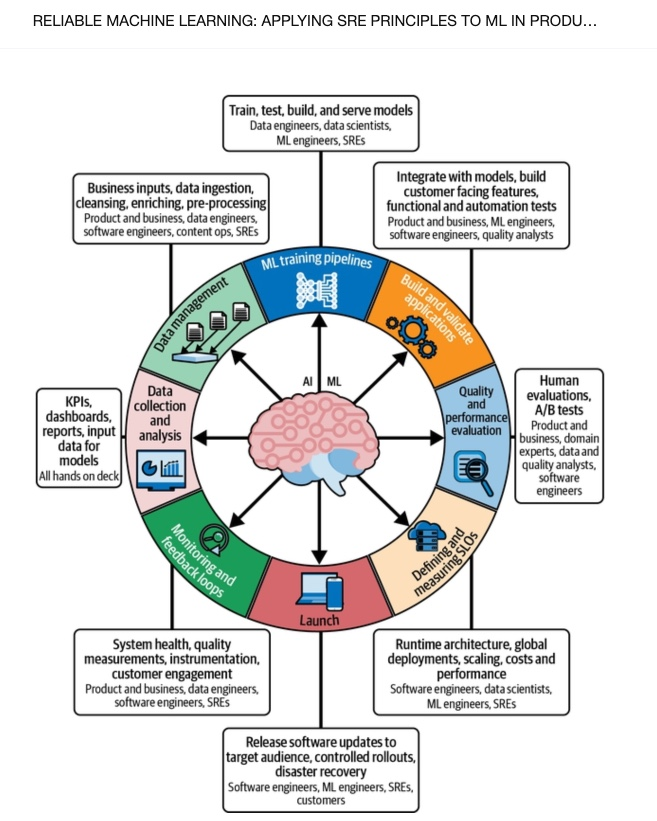

FOR REFERENCE

Nice example how to add a link for a downloadable file.

In [ ]:
# With weekly_aggregated_copy: create a csv version and download # 1. name of file: weekly_aggregated_copy (1)

from io import StringIO
import pandas as pd

# Create an in-memory CSV file
csv_buffer = StringIO()
weekly_aggregated_copy.to_csv(csv_buffer, index=False)

# Create a download link (this part depends on your environment)
# This will likely work in a Jupyter Notebook
import base64
from IPython.display import HTML

csv_data = csv_buffer.getvalue()
b64 = base64.b64encode(csv_data.encode()).decode()
href = f'<a href="data:file/csv;base64,{b64}" download="weekly_aggregated_copy.csv">Download CSV File</a>'
HTML(href)


<font size=6 color='Magenta'>Power Ahead</font>
___